## Simple Wave

In [ ]:
import numpy as np
import librosa
import librosa.display
import math
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.special import jv
import random
import IPython.display as ipd

class Generator:
  """ Base class for operators. 

  Attributes
  -----------------------
  sr : int
    sample rate to process at

  Methods
  -----------------------
  process : numpy.array
    returns a numpy array with sound intensity values [0,1] with length duration * sample rate. 
  """

  def __init__(self, sr, amplitude=1.0):
    self.sr = sr
    self.amplitude = amplitude

  def process(self, duration):
    pass

class SinWave(Generator):
  """ Simple sine wave operator.

  Attributes
  -----------------------
  sr : int
    sample rate 
  freq : int
    frequency of the sine wave.
  """

  def __init__(self,sr, freq, amplitude=1.0):
    self.sr = sr
    self.freq = freq
    self.amplitude = amplitude

  def process(self, duration):
      t = np.linspace(0, duration, math.floor(duration * self.sr), endpoint=False)
      s = np.sin(2*np.pi * t * self.freq)
      return self.amplitude * s


In [ ]:
sr = 44100
length = 1
sf.write("test_wave.wav", SinWave(sr, 440).process(length), sr)
ipd.Audio("test_wave.wav")

In [ ]:
test_wave, _sr = librosa.load("test_wave.wav")
print(test_wave)
print(_sr)

[ 0.01083915  0.12275696  0.24945952 ... -0.36627868 -0.2494894
 -0.12278916]
22050


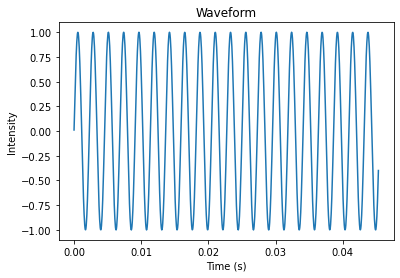

In [ ]:
def draw_waveform(data, sr, window=1000):
  xs = np.linspace(0, len(data) / sr, len(data), endpoint=False)
  plt.plot(xs[:window], data[:window])
  plt.xlabel("Time (s)")
  plt.ylabel("Intensity")
  plt.title("Waveform")
draw_waveform(test_wave, _sr)

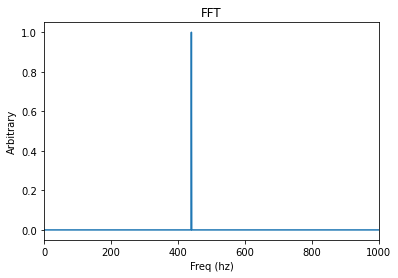

In [ ]:
def draw_fft(data, sr, xlim=[0,3000]):
  _fft = fft(data)
  x_fft = fftfreq(len(data), 1/_sr)[:len(data)//2]
  plt.plot(x_fft, 2 * np.abs(_fft[0:len(data)//2])/len(data))
  plt.xlim(left=xlim[0],right=xlim[1])
  plt.xlabel("Freq (hz)")
  plt.ylabel("Arbitrary")
  plt.title("FFT")
draw_fft(test_wave, _sr, xlim=[0,1000])

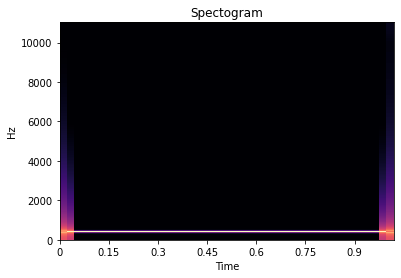

In [ ]:
def draw_spectogram(data, sr):
  x = librosa.stft(data, window="hann")
  librosa.display.specshow(librosa.amplitude_to_db(np.abs(x)), sr=sr, x_axis="time", y_axis="hz")
  plt.title("Spectogram")
draw_spectogram(test_wave, _sr)

## Classic FM


In [ ]:
class ClassicFM(Generator):
    """Simple FM operator using classic method. 
    ...
    sr : int
      sample rate 
    freq_c : int
      carrier frequency in hz
    freq_m : int 
      modulation frequency in hz
    beta  : float
      modulation index 
    """

    def __init__(self, sr, freq_c, freq_m=1, beta=1, amplitude=1.0):
        self.sr = sr
        self.freq_c = freq_c
        self.freq_m = freq_m
        self.beta = beta
        self.amplitude = amplitude
    def process(self, duration):
      t = np.linspace(0, duration, math.floor(duration * self.sr), endpoint=False)
      s = np.sin(2 * np.pi * self.freq_c * t + self.beta * np.sin(2*np.pi*self.freq_m*t))
      return self.amplitude * s 
freq_c = 440
freq_m = 8800
beta = 10.0
sf.write("classic_fm.wav", ClassicFM(sr, freq_c, freq_m=freq_m, beta=beta).process(length), sr)
ipd.Audio("classic_fm.wav")

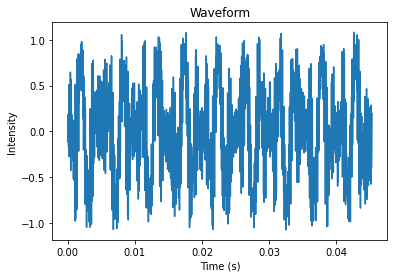

In [ ]:
classic, _sr = librosa.load("classic_fm.wav")
draw_waveform(classic, _sr)

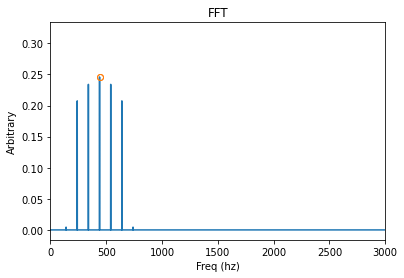

In [ ]:
draw_fft(classic, _sr,xlim=[0,3000])

# plot bessel functions associated with fm parameters
partials = 10
xs = []
ys = []
for n in range(0, partials):
  xs.append(freq_c + n * freq_m)
  ys.append(abs(jv(n, beta)))

  xs.append(abs(freq_c - n * freq_m))
  ys.append(abs(jv(-n, beta)))

plt.plot(xs, ys, 'o', fillstyle="none")

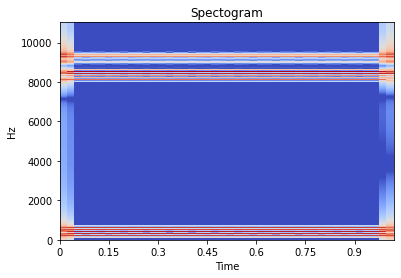

In [ ]:
draw_spectogram(classic, _sr)

##Modififed FM - Lazzarini and Timoney

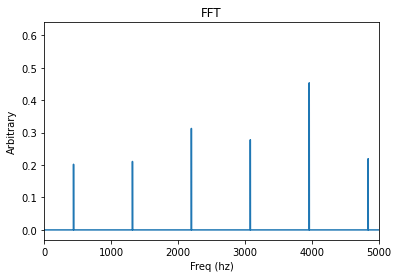

In [ ]:
class ModFM(Generator):
    """Modified FM  https://core.ac.uk/download/pdf/297015586.pdf
    ...
    sr : int
      sample rate 
    freq_c : int
      carrier frequency in hz
    freq_m : int 
      modulation frequency in hz
    k  : float
      modulation index 
    """

    def __init__(self, sr, freq_c, freq_m=1, beta=1, amplitude=1.0):
        self.sr = sr
        self.freq_c = freq_c
        self.freq_m = freq_m
        self.beta = beta
        self.amplitude = amplitude
    def process(self, duration):
      t = np.linspace(0, duration, math.floor(duration * self.sr), endpoint=False)
      s = np.exp(self.beta * np.cos(2 * np.pi * self.freq_m * t) - self.beta) * np.cos(2 * np.pi * self.freq_c * t)
      return self.amplitude * s
freq_c = 440
freq_m = 880
beta = 10.0
sf.write("mod_fm.wav", ClassicFM(sr, freq_c, freq_m=freq_m, beta=beta).process(length), sr)

mod, _sr = librosa.load("mod_fm.wav")
draw_fft(mod, _sr, xlim=[0,5000])
ipd.Audio("mod_fm.wav")

## Instruments
### Getting MIS files


In [ ]:
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Flute/Flute.vib.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Flute/Flute.nonvib.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Oboe/Oboe.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Bb%20Clarinet/BbClarinet.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Eb%20Alto%20Saxophone/AltoSax.vib.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Eb%20Alto%20Saxophone/AltoSax.NoVib.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Brass/BbTrumpet/Trumpet.vib.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Brass/BbTrumpet/Trumpet.novib.ff.stereo.zip
!wget http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Brass/Tenor%20Trombone/TenorTrombone.ff.stereo.zip


--2021-04-27 23:19:45--  http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Flute/Flute.vib.ff.stereo.zip
Resolving theremin.music.uiowa.edu (theremin.music.uiowa.edu)... 128.255.102.154, 2620:0:e50:680c::73
Connecting to theremin.music.uiowa.edu (theremin.music.uiowa.edu)|128.255.102.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451616 (13M) [application/x-zip-compressed]
Saving to: ‘Flute.vib.ff.stereo.zip.2’

Flute.vib.ff.stereo 100%[===================>]  12.83M  14.0MB/s    in 0.9s    

2021-04-27 23:19:46 (14.0 MB/s) - ‘Flute.vib.ff.stereo.zip.2’ saved [13451616/13451616]

--2021-04-27 23:19:46--  http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Flute/Flute.nonvib.ff.stereo.zip
Resolving theremin.music.uiowa.edu (theremin.music.uiowa.edu)... 128.255.102.154, 2620:0:e50:680c::73
Connecting to theremin.music.uiowa.edu (theremin.music.uiowa.edu)|128.255.102.154|:80... connected.
HTTP reque

In [ ]:
!unzip -o  Flute.vib.ff.stereo.zip 
!unzip -o Flute.nonvib.ff.stereo.zip
!unzip -o Oboe.ff.stereo.zip
!unzip -o BbClarinet.ff.stereo.zip
!unzip -o AltoSax.vib.ff.stereo.zip
!unzip -o AltoSax.NoVib.ff.stereo.zip
!unzip -o Trumpet.vib.ff.stereo.zip
!unzip -o Trumpet.novib.ff.stereo.zip
!unzip -o TenorTrombone.ff.stereo.zip

Archive:  Flute.vib.ff.stereo.zip
  inflating: Flute.vib.ff.A4.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.A4.stereo.aif  
  inflating: Flute.vib.ff.A5.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.A5.stereo.aif  
  inflating: Flute.vib.ff.A6.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.A6.stereo.aif  
  inflating: Flute.vib.ff.Ab4.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.Ab4.stereo.aif  
  inflating: Flute.vib.ff.Ab5.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.Ab5.stereo.aif  
  inflating: Flute.vib.ff.Ab6.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.Ab6.stereo.aif  
  inflating: Flute.vib.ff.B3.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.B3.stereo.aif  
  inflating: Flute.vib.ff.B4.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.B4.stereo.aif  
  inflating: Flute.vib.ff.B5.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.B5.stereo.aif  
  inflating: Flute.vib.ff.B6.stereo.aif  
  inflating: __MACOSX/._Flute.vib.ff.B6.stereo.aif  
  inflatin

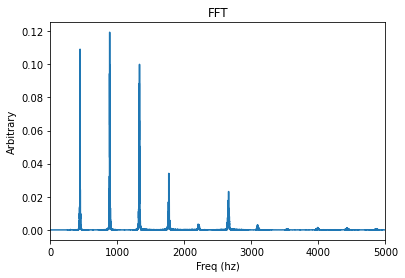

In [ ]:
flutea4, _sr = librosa.load("Flute.nonvib.ff.A4.stereo.aif")
flutea4_norm = librosa.util.normalize(flutea4)
draw_fft(flutea4_norm, _sr, xlim=[0,5000])
ipd.Audio("Flute.nonvib.ff.A4.stereo.aif")

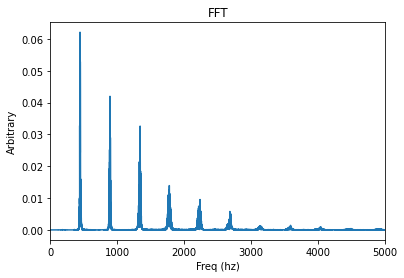

In [ ]:
flutea4_vib, _sr = librosa.load("Flute.vib.ff.A4.stereo.aif")
flutea4_vib_norm = librosa.util.normalize(flutea4_vib)
draw_fft(flutea4_vib_norm, _sr, xlim=[0,5000])

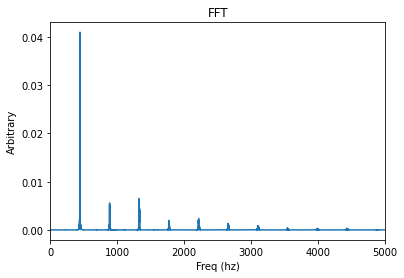

In [ ]:
altosax, _sr = librosa.load("AltoSax.NoVib.ff.A4.stereo.aif")
draw_fft(altosax, _sr, xlim=[0,5000])

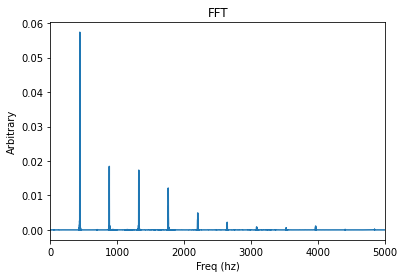

In [ ]:
clarinet, _sr = librosa.load("BbClarinet.ff.A4.stereo.aif")
draw_fft(clarinet, _sr, xlim=[0,5000])

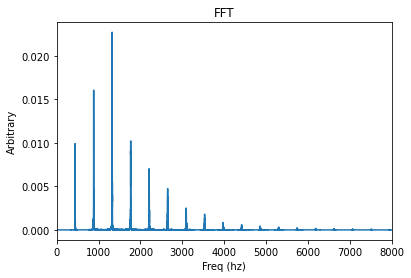

In [ ]:
trump, _sr = librosa.load("Trumpet.novib.ff.A4.stereo.aif")
draw_fft(trump, _sr, xlim=[0,8000])

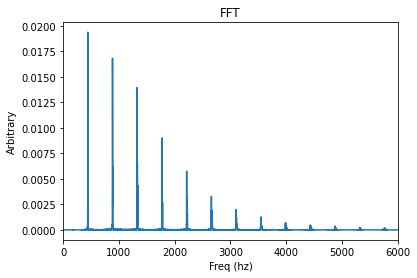

In [ ]:
tromb, _sr = librosa.load("TenorTrombone.ff.A4.stereo.aif")
draw_fft(tromb, _sr, xlim=[0,6000])

(array([  0.        ,  10.75609756,  21.51219512, ..., -32.26829268,
        -21.51219512, -10.75609756]),
 array([6.5009907e-08, 6.6274231e-07, 8.3105107e-07, ..., 3.3963343e-09,
        2.8583971e-09, 3.9106660e-09], dtype=float32))

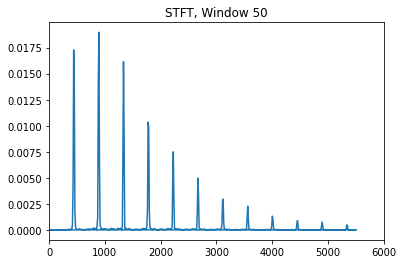

In [ ]:
def plot_stft_window(mat,slice, sr=sr, xlim=[0,6000]):
  xs = fftfreq(len(mat[:,slice]),d=1/sr)[:len(mat[:,slice]//2)]  / 2
  nor = np.abs(mat[:,slice]) / len(mat[:,slice])
  plt.plot(xs, nor[:len(mat[:,slice]//2)])
  plt.xlim(left=xlim[0],right=xlim[1])
  plt.title("STFT, Window %d" % slice)
  return xs, nor[:len(mat[:,slice]//2)]
#copy pasted from above without the plot
def get_stft_window(mat,slice, sr=sr):
  xs = fftfreq(len(mat[:,slice]),d=1/sr)[:len(mat[:,slice]//2)]  / 2
  nor = np.abs(mat[:,slice]) / len(mat[:,slice])
  return xs, nor[:len(mat[:,slice]//2)]
  
d = librosa.stft(tromb, n_fft=2048,hop_length=256, win_length=2048)
plot_stft_window(d,50, sr=_sr)

# Optimization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, 'Smearing of simulated FFT')

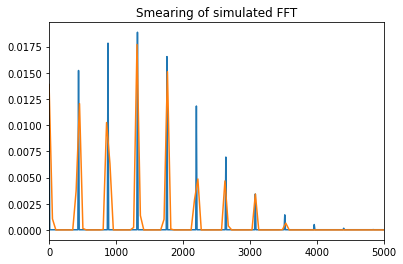

In [ ]:
class HarmonicModFm(ModFM):
  def __init__(self, amplitude, harm, multiplier, index, f0=440, sr=44100):
    self.amplitude = amplitude
    self.harm = harm
    self.multiplier = multiplier
    self.index = index
    self.f0 = f0
    self.sr = sr
  def process(self, duration):
    self.freq_c = self.f0 * (self.harm + 1)
    self.freq_m = self.f0 * self.multiplier
    self.beta = self.index
    return super().process(duration)
   

class Mixer:
  def __init__(self):
    self.waves = []
  def add_wave(self, wave):
    self.waves.append(wave)
  def get_sound(self, duration):
    out = self.waves[0].process(duration)
    for i in range(1,len(self.waves)):
      out = np.add(out, self.waves[i].process(duration))
    
    out = out / len(self.waves)
    return out


num_waves = 4
parameters = ["amplitude", "harm", "multiplier", "index"]
defaults = [0.1, 2, 1, 5.0]
types = ["float", "int","int","float"]
ranges = [[0.1,1],[0,8],[0,4],[1.0,20.0]]

mixer = Mixer()
for i in range(num_waves):
  mixer.add_wave(HarmonicModFm(defaults[0],defaults[1],defaults[2], defaults[3]))

sr = 44100
sound = mixer.get_sound(0.1)


sf.write("test.wav", sound, sr)
ipd.Audio("test.wav")
test, _sr = librosa.load("test.wav")

y_fft = fft(test)
x_fft = fftfreq(len(test), 1/_sr)[:len(test)//2]
y_fft = 2 * np.abs(y_fft[:len(test)//2]) / len(test)
plt.plot(x_fft, y_fft)
plt.xlim(left=0,right=5000)

def smear(xs, ys, sigmasquared=1500,thresh=0.00005, xout=np.linspace(0,5000,100),decay=0):
  peaks = [[xs[x],val] for x,val in enumerate(ys) if val > thresh]
  y_smeared = np.zeros(len(xout))
  for p in peaks:
    y_smeared += p[1] * np.exp(-0.5 * (xout - p[0])**2 / (sigmasquared - np.clip(decay * xout,0,None)))

  return xout, y_smeared

xs, y_smeared = smear(x_fft, y_fft, thresh=0.001, sigmasquared=500,decay=0.1)
plt.plot(xs, y_smeared)
plt.title("Smearing of simulated FFT")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Trombone sample (orange) and smeared default wave (blue)')

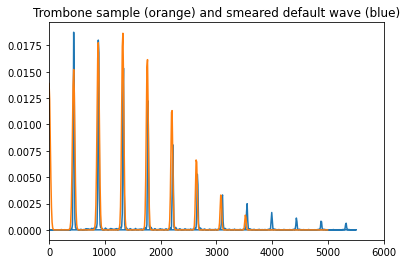

In [ ]:
_xs, smp = plot_stft_window(d, 100, sr=_sr)
xs, y_smeared = smear(x_fft, y_fft, thresh=0.001, sigmasquared=500,xout=_xs,decay=0.1)
plt.plot(xs, y_smeared)

plt.title("Trombone sample (orange) and smeared default wave (blue)")


In [ ]:
def penalty(xs, sim_ys, target_ys):
  return 10000 * np.sum(np.square(sim_ys - target_ys))

penalty(xs, smp, y_smeared)

inf

# Gradient Descent For a Single Carrier

Starting penalty function: 1957.899973
Pass 1, new penalty function: 2030.1
-----> {'amplitude': 0.059489101522142394, 'harm': 7, 'multiplier': 2, 'index': 7.93580462423804}
Pass 2, new penalty function: 2035.7
-----> {'amplitude': 0.06267263911008968, 'harm': 8, 'multiplier': 10, 'index': 8.089259583565127}
Pass 3, new penalty function: 2017.6
-----> {'amplitude': 0.0703124826743408, 'harm': 0, 'multiplier': 10, 'index': 8.032159724081499}
Pass 4, new penalty function: 2300.1
-----> {'amplitude': 0.07553394324007627, 'harm': 4, 'multiplier': 10, 'index': 7.970630020110116}
Pass 5, new penalty function: 2046.5
-----> {'amplitude': 0.056363345167809484, 'harm': 8, 'multiplier': 10, 'index': 8.145581193255726}
Pass 6, new penalty function: 2023.4
-----> {'amplitude': 0.06560050346855632, 'harm': 0, 'multiplier': 10, 'index': 8.085235695776488}
Pass 7, new penalty function: 2140.0
-----> {'amplitude': 0.07218208602085838, 'harm': 3, 'multiplier': 10, 'index': 8.018066480946368}
Pass 8, ne

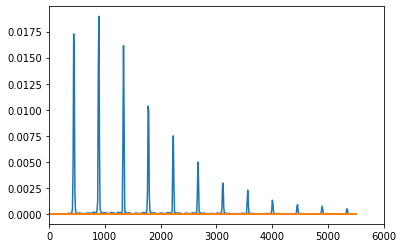

In [ ]:
class GradientOptimizedCarrier:
  def __init__(self, defaults={}, penalty=penalty,types={}, par_range={}, steps={},gammas={}):
    self.carrier = HarmonicModFm(defaults["amplitude"], defaults["harm"], defaults["multiplier"],defaults["index"])
    self.vars = defaults
    self.penalty = penalty
    self.steps = steps
    self.types = types
    self.par_range = par_range
    self.grads = {k:0 for k,v in defaults.items()}
    self.last_pen = -1
    self.gamma = 0.1
    self.gammas = gammas
    self.sigsquared = 200.0
    self.sigdecay = 0.01
    self.cached_xs = None
    self.cached_smp = None
    self.sample_points = 10000
  def _get_stft_window(self, mat,slize, sr=sr):
    xs = fftfreq(len(mat[:,slize]),d=1/sr)[:len(mat[:,slize]//2)]  / 2
    nor = np.abs(mat[:,slize]) / len(mat[:,slize])
    return xs, nor[:len(mat[:,slize]//2)]

  def _do_stft(self, sample):
    return librosa.stft(sample, n_fft=2048,hop_length=256, win_length=2048)

  def get_penalty(self, sample, slize, use_cached_sample=True, sample_sr=44100):
    if use_cached_sample and self.cached_smp is not None:
      _xs = self.cached_xs
      smp = self.cached_smp

    else:
      _xs, smp = self._get_stft_window(self._do_stft(sample), slize, sr=sample_sr)
      if use_cached_sample:
        self.cached_xs = _xs
        self.cached_smp = smp

    car_out = self.carrier.process(1)
    y_fft = fft(car_out)
    x_fft = fftfreq(len(car_out), 1/self.carrier.sr)[:len(car_out)//2]
    y_fft = 2 * np.abs(y_fft[:len(car_out)//2]) / len(car_out)
    _xout = np.linspace(0,5000,self.sample_points)
    __xs, ysmr = smear(x_fft, y_fft, thresh=0.001,sigmasquared=self.sigsquared,xout=_xout)
    ___xs, _smp = smear(_xs, smp, sigmasquared=self.sigsquared, thresh=0.001, xout=_xout)
    return self.penalty(_xout, _smp, ysmr)


  
  def _grad(self, sample, slize, sample_sr=44100):
    for par in self.grads.keys():
      self.vars[par] += self.steps[par]
      setattr(self.carrier,par,self.vars[par])
      pen = self.get_penalty(sample,slize)
      self.grads[par] = (pen - self.last_pen) / self.steps[par]
      self.vars[par] -= self.steps[par]
      setattr(self.carrier,par,self.vars[par])

  def _update(self, dropout=0):
    for par in self.grads.keys():
      if random.random() < dropout: continue
      self.vars[par] = self.vars[par] - self.gammas[par] * self.grads[par]
      self.vars[par] = self._clamp(self.par_range[par][0], self.par_range[par][1], self.vars[par])
      if self.types[par] == "int":
        self.vars[par] = round(self.vars[par])

      setattr(self.carrier,par,self.vars[par])
  def do_pass(self, sample, slize, sample_sr=44100):
    if self.last_pen == -1:
      self.last_pen = self.get_penalty(sample,slize, sample_sr=sample_sr)
      print("Starting penalty function: %f" % self.last_pen)

    #estimate gradient
    self._grad(sample,slize,sample_sr)
    
    #update parameters
    self._update()
    
    self.last_pen = self.get_penalty(sample, slize)
    return self.last_pen
    
  def plot_progress(self, sample, slize, sample_sr=44100):
    _xs, smp = self._get_stft_window(self._do_stft(sample), slize, sr=sample_sr)
    car_out = self.carrier.process(1)
    y_fft = fft(car_out)
    x_fft = fftfreq(len(car_out), 1/self.carrier.sr)[:len(car_out)//2]
    y_fft = 2 * np.abs(y_fft[:len(car_out)//2]) / len(car_out)
    __xs, ysmr = smear(x_fft, y_fft, thresh=0.001,sigmasquared=self.sigsquared,decay=self.sigdecay,xout=_xs)

    plt.plot(_xs, smp)
    plt.plot(_xs, ysmr)
    plt.xlim(left=0,right=6000)

  def _clamp(self, _min, _max, val):
    return min(_max, max(_min,val))

test, _sr = librosa.load("TenorTrombone.ff.A4.stereo.aif")

gtest = GradientOptimizedCarrier(defaults={"amplitude":0.05,"harm": 5.0, "multiplier": 4.0, "index":8},
                                 steps={"amplitude":-0.001,"harm":1.0, "multiplier":1.0, "index":0.1},
                                 gammas={"amplitude":0.000005,"harm":0.1, "multiplier":0.1,"index":0.01},
                                 types={"amplitude":"float","harm":"int","multiplier":"int","index":"float"},
                                 par_range={"amplitude":(0.001,0.3),"harm":(0,8),"multiplier":(0,10),"index":(0.1,50)})
pen = 1000000
lastBest = 0
best = pen
best_pars = None
bestBy = 0.1
iter = 0
cutoff = 20

while pen > 1:
  iter+= 1
  new_pen = gtest.do_pass(test, 50, sample_sr=_sr)
  if new_pen < best - bestBy: 
    lastBest = iter
    best = new_pen
    best_pars = gtest.vars
  pen = new_pen
  print("Pass {}, new penalty function: {:.5}".format(iter, pen))
  print("-----> "+str(gtest.vars))

  if iter - lastBest > cutoff:
    break

print("Best parameters: ", best_pars)
print("Penalty function: ", best)
gtest.vars = best_pars
gtest.plot_progress(test, 50, sample_sr=_sr)


# Gradient Descent for Multiple Carriers with Learned Harmonics

Pass 1, new penalty function: 15.694
-----> {'amplitude': 0.009727205603850608, 'harm': 6, 'multiplier': 0, 'index': 3.8310872915040997}
-----> {'amplitude': 0.011125372112684011, 'harm': 7.5314504403946785, 'multiplier': 0, 'index': 5.481029762317058}
-----> {'amplitude': 0.012370305417125254, 'harm': 5, 'multiplier': 0, 'index': 5.475293443374141}
-----> {'amplitude': 0.012939538833792176, 'harm': 5, 'multiplier': 0, 'index': 5.699686762479044}


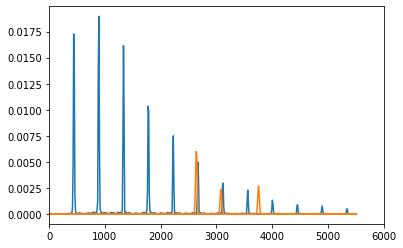

Pass 2, new penalty function: 15.524
-----> {'amplitude': 0.010614240882539993, 'harm': 6, 'multiplier': 0, 'index': 3.813336884037724}
-----> {'amplitude': 0.011125372112684011, 'harm': 7, 'multiplier': 0, 'index': 5.462744600706033}
-----> {'amplitude': 0.013189774254539788, 'harm': 5.0, 'multiplier': 0, 'index': 5.4589050923377505}
-----> {'amplitude': 0.012939538833792176, 'harm': 5, 'multiplier': 0, 'index': 5.683302340528326}


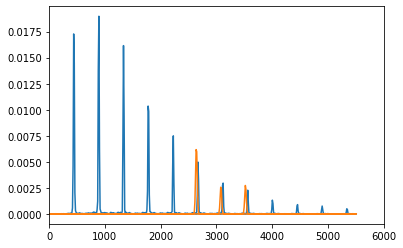

Pass 3, new penalty function: 15.496
-----> {'amplitude': 0.011505754098980655, 'harm': 6, 'multiplier': 0, 'index': 3.795496028518177}
-----> {'amplitude': 0.011986994356033008, 'harm': 7, 'multiplier': 0, 'index': 5.4455069749859275}
-----> {'amplitude': 0.01400897059407067, 'harm': 5, 'multiplier': 0, 'index': 5.442521369699694}
-----> {'amplitude': 0.013758782682645297, 'harm': 5, 'multiplier': 0, 'index': 5.683302340528326}


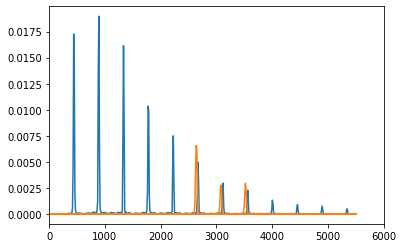

Pass 4, new penalty function: 15.472
-----> {'amplitude': 0.012402165269835714, 'harm': 6, 'multiplier': 0.0, 'index': 3.795496028518177}
-----> {'amplitude': 0.0128510130447133, 'harm': 7.0, 'multiplier': 0, 'index': 5.428220556538916}
-----> {'amplitude': 0.014828230979583542, 'harm': 5, 'multiplier': 0, 'index': 5.426135544855852}
-----> {'amplitude': 0.014577987827548435, 'harm': 5, 'multiplier': 0, 'index': 5.6669178713228305}


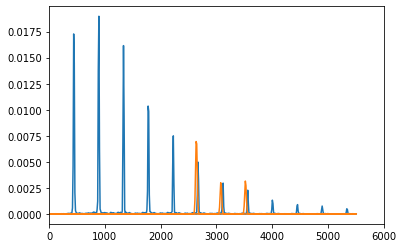

Pass 5, new penalty function: 15.461
-----> {'amplitude': 0.013303903005359271, 'harm': 6, 'multiplier': 0.0, 'index': 3.77744889013151}
-----> {'amplitude': 0.013717808541397892, 'harm': 7, 'multiplier': 0, 'index': 5.410877735708979}
-----> {'amplitude': 0.015647891852838967, 'harm': 5, 'multiplier': 0, 'index': 5.4097408889068035}
-----> {'amplitude': 0.014577987827548435, 'harm': 5, 'multiplier': 0, 'index': 5.650526626615173}


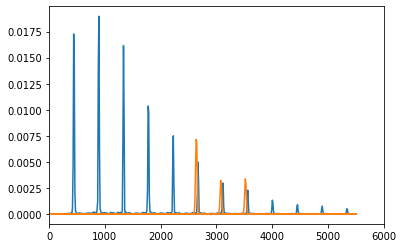

Pass 6, new penalty function: 15.441
-----> {'amplitude': 0.014211405355314524, 'harm': 6, 'multiplier': 0, 'index': 3.7592855554181}
-----> {'amplitude': 0.014587765792566057, 'harm': 7, 'multiplier': 0, 'index': 5.39347081078264}
-----> {'amplitude': 0.016468290106261777, 'harm': 5, 'multiplier': 0, 'index': 5.393330663602542}
-----> {'amplitude': 0.015397490682810976, 'harm': 5, 'multiplier': 0, 'index': 5.634135381907516}


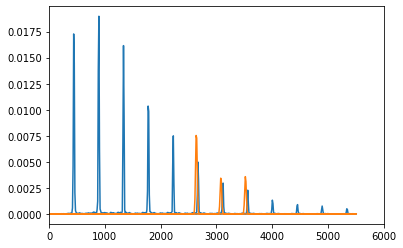

Pass 7, new penalty function: 15.423
-----> {'amplitude': 0.015125120691176277, 'harm': 6, 'multiplier': 0, 'index': 3.7409970511691313}
-----> {'amplitude': 0.015461275019902767, 'harm': 7, 'multiplier': 0, 'index': 5.375991974156379}
-----> {'amplitude': 0.017289763636730567, 'harm': 5, 'multiplier': 0, 'index': 5.376898110266236}
-----> {'amplitude': 0.016217627944562205, 'harm': 5.0, 'multiplier': 0, 'index': 5.617730627476641}


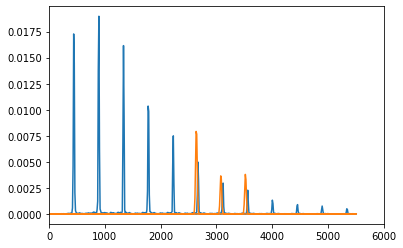

Pass 8, new penalty function: 15.399
-----> {'amplitude': 0.015125120691176277, 'harm': 6, 'multiplier': 0, 'index': 3.7225741788446642}
-----> {'amplitude': 0.016338732430667004, 'harm': 7, 'multiplier': 0, 'index': 5.358433298123979}
-----> {'amplitude': 0.018112651902321926, 'harm': 5, 'multiplier': 0, 'index': 5.360436438658332}
-----> {'amplitude': 0.017038737144024412, 'harm': 5, 'multiplier': 0, 'index': 5.601305612062078}


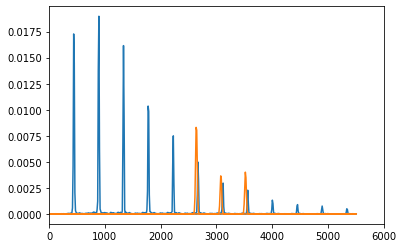

Pass 9, new penalty function: 15.387
-----> {'amplitude': 0.016045508628499714, 'harm': 6, 'multiplier': 0, 'index': 3.704151306520197}
-----> {'amplitude': 0.017220540949812606, 'harm': 7, 'multiplier': 0, 'index': 5.340786720228108}
-----> {'amplitude': 0.018937296483959174, 'harm': 5, 'multiplier': 0, 'index': 5.343938815742019}
-----> {'amplitude': 0.017861157203148816, 'harm': 5, 'multiplier': 0, 'index': 5.584853556250386}


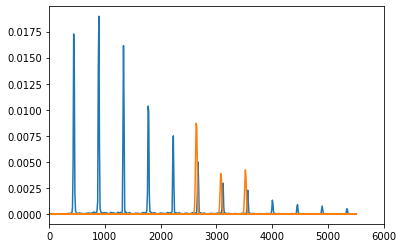

Pass 10, new penalty function: 15.377
-----> {'amplitude': 0.016973040993610827, 'harm': 6, 'multiplier': 0, 'index': 3.6855846229040887}
-----> {'amplitude': 0.0181071109767826, 'harm': 7, 'multiplier': 0, 'index': 5.323044028117697}
-----> {'amplitude': 0.019764041653942074, 'harm': 5.0, 'multiplier': 0, 'index': 5.327398354310507}
-----> {'amplitude': 0.01868522899455821, 'harm': 5, 'multiplier': 0, 'index': 5.584853556250386}


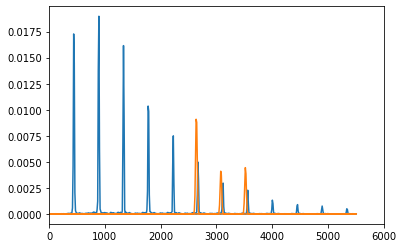

Pass 11, new penalty function: 15.377
-----> {'amplitude': 0.017908202839080147, 'harm': 6, 'multiplier': 0, 'index': 3.666864419782274}
-----> {'amplitude': 0.018998861170055475, 'harm': 7, 'multiplier': 0, 'index': 5.305196843849521}
-----> {'amplitude': 0.019764041653942074, 'harm': 5, 'multiplier': 0, 'index': 5.3108081014358035}
-----> {'amplitude': 0.019511295907763352, 'harm': 5, 'multiplier': 0, 'index': 5.568326912664953}


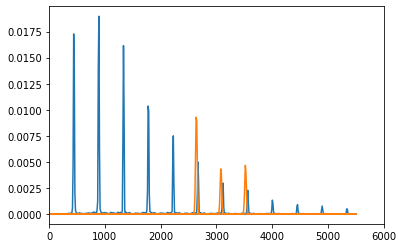

Pass 12, new penalty function: 15.36
-----> {'amplitude': 0.017908202839080147, 'harm': 6, 'multiplier': 0, 'index': 3.647980702548287}
-----> {'amplitude': 0.019896219262701357, 'harm': 7, 'multiplier': 0, 'index': 5.287236607568798}
-----> {'amplitude': 0.02059323495337282, 'harm': 5, 'multiplier': 0, 'index': 5.2942178485611}
-----> {'amplitude': 0.020339704423655337, 'harm': 5, 'multiplier': 0, 'index': 5.551752608851538}


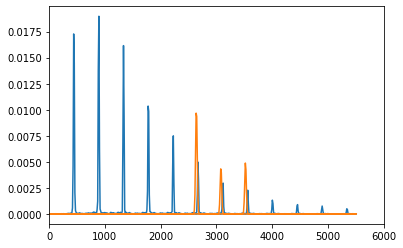

Pass 13, new penalty function: 15.357
-----> {'amplitude': 0.018851493512783847, 'harm': 6, 'multiplier': 0.0, 'index': 3.6290969853143}
-----> {'amplitude': 0.02079962291240887, 'harm': 7, 'multiplier': 0, 'index': 5.2691545604995484}
-----> {'amplitude': 0.021425227780544627, 'harm': 5, 'multiplier': 0, 'index': 5.277570773822967}
-----> {'amplitude': 0.021170804699323253, 'harm': 5, 'multiplier': 0, 'index': 5.53512363932078}


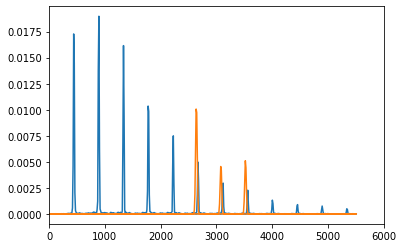

Pass 14, new penalty function: 15.362
-----> {'amplitude': 0.019803427785738396, 'harm': 6, 'multiplier': 0, 'index': 3.6100394503982454}
-----> {'amplitude': 0.021709520589672324, 'harm': 7, 'multiplier': 0.0, 'index': 5.250941727170908}
-----> {'amplitude': 0.02226037599242301, 'harm': 5, 'multiplier': 0.0, 'index': 5.2608597572754245}
-----> {'amplitude': 0.021170804699323253, 'harm': 5, 'multiplier': 0, 'index': 5.5184329127632665}


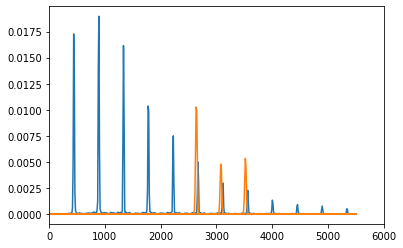

Pass 15, new penalty function: 15.368
-----> {'amplitude': 0.020764537044321255, 'harm': 6, 'multiplier': 0, 'index': 3.590797461406925}
-----> {'amplitude': 0.022626372508085336, 'harm': 7, 'multiplier': 0, 'index': 5.232588896800409}
-----> {'amplitude': 0.02309904052142695, 'harm': 5, 'multiplier': 0, 'index': 5.244077577106658}
-----> {'amplitude': 0.021170804699323253, 'harm': 5, 'multiplier': 0, 'index': 5.501742186205753}


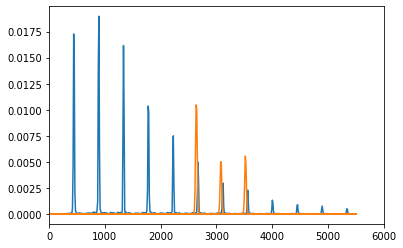

Pass 16, new penalty function: 15.373
-----> {'amplitude': 0.02173537055296525, 'harm': 6, 'multiplier': 0, 'index': 3.5713600238532903}
-----> {'amplitude': 0.022626372508085336, 'harm': 7, 'multiplier': 0.0, 'index': 5.214086603749537}
-----> {'amplitude': 0.023941588009808192, 'harm': 5, 'multiplier': 0, 'index': 5.244077577106658}
-----> {'amplitude': 0.022004951165306458, 'harm': 5, 'multiplier': 0, 'index': 5.48505145964824}


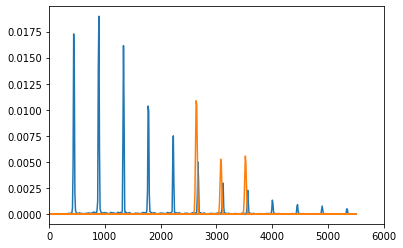

Pass 17, new penalty function: 15.379
-----> {'amplitude': 0.022716496793943834, 'harm': 6, 'multiplier': 0, 'index': 3.5517157583428154}
-----> {'amplitude': 0.023550651600974554, 'harm': 7, 'multiplier': 0, 'index': 5.195584310698664}
-----> {'amplitude': 0.024788391464032927, 'harm': 5, 'multiplier': 0, 'index': 5.227130932932612}
-----> {'amplitude': 0.02284250313746359, 'harm': 5, 'multiplier': 0, 'index': 5.468291786692837}


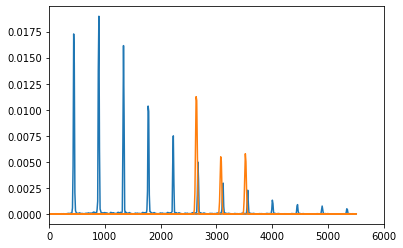

Pass 18, new penalty function: 15.388
-----> {'amplitude': 0.023708504891454606, 'harm': 6, 'multiplier': 0, 'index': 3.531852872072559}
-----> {'amplitude': 0.023550651600974554, 'harm': 7, 'multiplier': 0, 'index': 5.176922813909535}
-----> {'amplitude': 0.025639830931691806, 'harm': 5, 'multiplier': 0, 'index': 5.210090719526195}
-----> {'amplitude': 0.023683825445727287, 'harm': 5, 'multiplier': 0, 'index': 5.451455867326699}


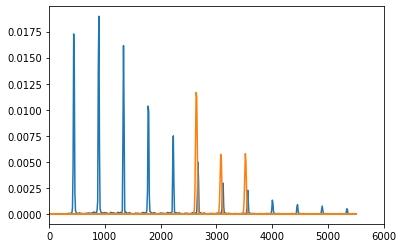

Pass 19, new penalty function: 15.4
-----> {'amplitude': 0.024712006127866483, 'harm': 6, 'multiplier': 0, 'index': 3.511759128485526}
-----> {'amplitude': 0.024482844548928132, 'harm': 7, 'multiplier': 0, 'index': 5.158261317120405}
-----> {'amplitude': 0.026496294203602996, 'harm': 5.0, 'multiplier': 0, 'index': 5.1929491764232045}
-----> {'amplitude': 0.024529289082114807, 'harm': 5, 'multiplier': 0.0, 'index': 5.434536277929524}


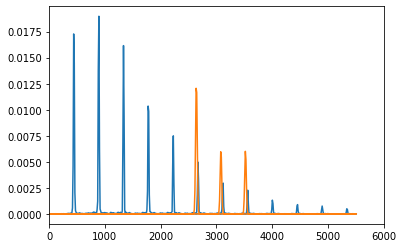

Pass 20, new penalty function: 15.416
-----> {'amplitude': 0.02572763556072958, 'harm': 6, 'multiplier': 0, 'index': 3.4914218149082554}
-----> {'amplitude': 0.02542345286313202, 'harm': 7, 'multiplier': 0, 'index': 5.139430578435255}
-----> {'amplitude': 0.027358177543930003, 'harm': 5.0, 'multiplier': 0, 'index': 5.175698373303749}
-----> {'amplitude': 0.025379271870481612, 'harm': 5, 'multiplier': 0, 'index': 5.417525457872313}


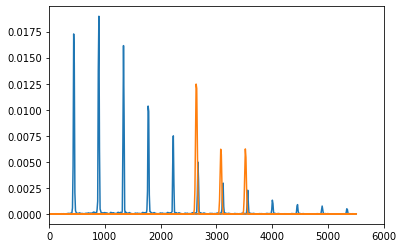

Pass 21, new penalty function: 15.434
-----> {'amplitude': 0.026756053749965706, 'harm': 6, 'multiplier': 0, 'index': 3.4708277079831755}
-----> {'amplitude': 0.02637299402982663, 'harm': 7, 'multiplier': 0.0, 'index': 5.120420239692443}
-----> {'amplitude': 0.028225886451312823, 'harm': 5, 'multiplier': 0, 'index': 5.158330194761135}
-----> {'amplitude': 0.026234159160638343, 'harm': 5, 'multiplier': 0, 'index': 5.40041569562817}


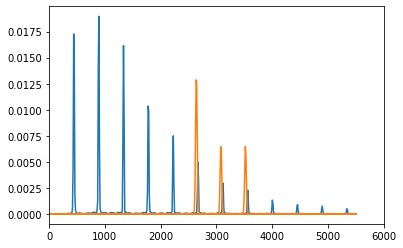

Pass 22, new penalty function: 15.456
-----> {'amplitude': 0.027797948605571634, 'harm': 6, 'multiplier': 0, 'index': 3.4499630366889695}
-----> {'amplitude': 0.027332002721641525, 'harm': 7.0, 'multiplier': 0, 'index': 5.101219598483737}
-----> {'amplitude': 0.029099836454209344, 'harm': 5, 'multiplier': 0, 'index': 5.140836324385774}
-----> {'amplitude': 0.02709434454960298, 'harm': 5, 'multiplier': 0, 'index': 5.383199114339723}


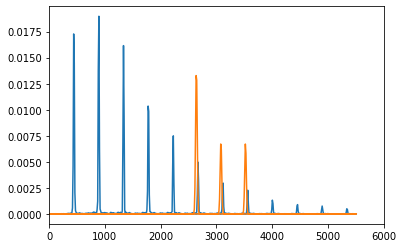

Pass 23, new penalty function: 15.477
-----> {'amplitude': 0.028854037367189056, 'harm': 6, 'multiplier': 0, 'index': 3.428813442721758}
-----> {'amplitude': 0.028301032082061625, 'harm': 7, 'multiplier': 0, 'index': 5.08181758244776}
-----> {'amplitude': 0.029099836454209344, 'harm': 5, 'multiplier': 0, 'index': 5.123208228095727}
-----> {'amplitude': 0.02709434454960298, 'harm': 5.0, 'multiplier': 0, 'index': 5.365867656784259}


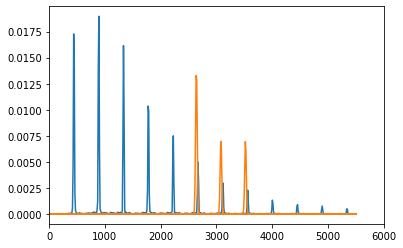

Pass 24, new penalty function: 15.504
-----> {'amplitude': 0.029925068728038136, 'harm': 6, 'multiplier': 0, 'index': 3.4073639379870215}
-----> {'amplitude': 0.02928065508983071, 'harm': 7, 'multiplier': 0, 'index': 5.0622027219634065}
-----> {'amplitude': 0.029980453943865802, 'harm': 5, 'multiplier': 0, 'index': 5.10558013180568}
-----> {'amplitude': 0.02796023063293049, 'harm': 5, 'multiplier': 0, 'index': 5.3485361992287945}


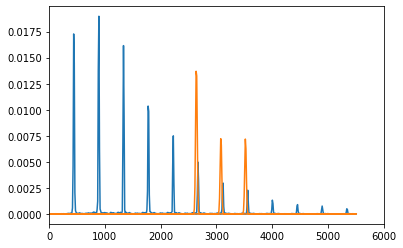

Pass 25, new penalty function: 15.535
-----> {'amplitude': 0.03101182511699138, 'harm': 6, 'multiplier': 0.0, 'index': 3.3855988589265924}
-----> {'amplitude': 0.030271466010713323, 'harm': 7, 'multiplier': 0, 'index': 5.042363121094713}
-----> {'amplitude': 0.030868177048582655, 'harm': 5, 'multiplier': 0.0, 'index': 5.08780904035044}
-----> {'amplitude': 0.028832229789253913, 'harm': 5, 'multiplier': 0, 'index': 5.331081612118414}


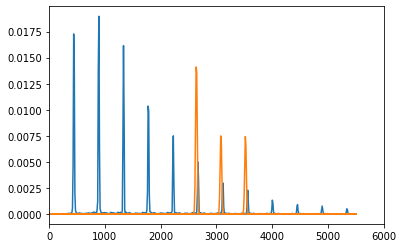

Pass 26, new penalty function: 15.543
-----> {'amplitude': 0.03101182511699138, 'harm': 6, 'multiplier': 0, 'index': 3.3635018173763185}
-----> {'amplitude': 0.03127408194472184, 'harm': 7, 'multiplier': 0, 'index': 5.0222864266249765}
-----> {'amplitude': 0.03176345655321821, 'harm': 5, 'multiplier': 0, 'index': 5.0698859309091}
-----> {'amplitude': 0.028832229789253913, 'harm': 5, 'multiplier': 0, 'index': 5.313495429668208}


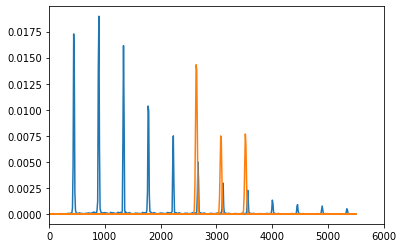

Pass 27, new penalty function: 15.579
-----> {'amplitude': 0.032115125153999204, 'harm': 6, 'multiplier': 0, 'index': 3.3414047758260446}
-----> {'amplitude': 0.032289144477680345, 'harm': 7, 'multiplier': 0, 'index': 5.0019597950025885}
-----> {'amplitude': 0.03266675686817929, 'harm': 5, 'multiplier': 0, 'index': 5.051801507697847}
-----> {'amplitude': 0.029710765001385347, 'harm': 5.0, 'multiplier': 0, 'index': 5.2959092472180025}


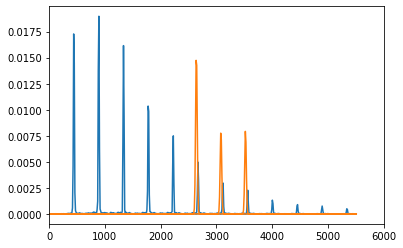

Pass 28, new penalty function: 15.619
-----> {'amplitude': 0.0332358262956887, 'harm': 6, 'multiplier': 0, 'index': 3.3189586060675325}
-----> {'amplitude': 0.033317321446850075, 'harm': 7, 'multiplier': 0, 'index': 4.9813698570039735}
-----> {'amplitude': 0.03357855705248976, 'harm': 5, 'multiplier': 0, 'index': 5.033546181494931}
-----> {'amplitude': 0.03059627071756463, 'harm': 5, 'multiplier': 0, 'index': 5.278182773910445}


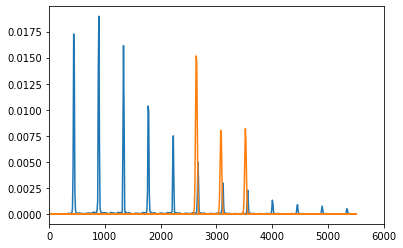

Best parameters:  {'amplitude': 0.0332358262956887, 'harm': 6, 'multiplier': 0, 'index': 3.3189586060675325}
{'amplitude': 0.033317321446850075, 'harm': 7, 'multiplier': 0, 'index': 4.9813698570039735}
{'amplitude': 0.03357855705248976, 'harm': 5, 'multiplier': 0, 'index': 5.033546181494931}
{'amplitude': 0.03059627071756463, 'harm': 5, 'multiplier': 0, 'index': 5.278182773910445}
Penalty function:  15.423342616525034


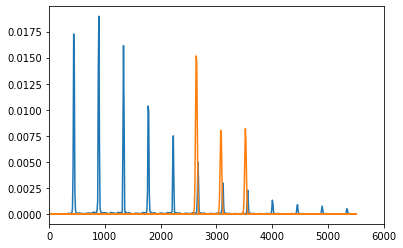

In [ ]:
class GradientOptimizedMixer:
  def __init__(self, num_operators=4, defaults={}, penalty=penalty,types={},par_range={}, steps={},gammas={},defstd={}):
    self.operators = []
    for i in range(num_operators):
        self.operators.append(GradientOptimizedCarrier(defaults={d:i+random.gauss(0,defstd[d]) for d,i in defaults.items()},penalty=penalty,types=types,par_range=par_range,steps=steps,gammas=gammas))

    self.last_pen = 10000
    self.cached_xs = None
    self.cached_smp = None
    self.penalty = penalty
    self.sigsquared = 200.0
    self.sample_points=5000
    self.sigdecay = 0.01

  def _output(self):
    out = self.operators[0].carrier.process(1)
    for i in range(1, len(self.operators)):
        out = np.add(out, self.operators[i].carrier.process(1))
    return out / len(self.operators)

  def _vars(self):
    return [o.vars for o in self.operators]

  def set_vars(self,vars):
    for i in range(len(vars)):
      self.operators[i].vars = vars[i]
      
  def plot_progress(self, sample, slize, sample_sr=44100):
      _xs, smp = self._get_stft_window(self._do_stft(sample), slize, sr=sample_sr)
      car_out = self._output()
      y_fft = fft(car_out)
      x_fft = fftfreq(len(car_out), 1/self.operators[0].carrier.sr)[:len(car_out)//2]
      y_fft = 2 * np.abs(y_fft[:len(car_out)//2]) / len(car_out)
      __xs, ysmr = smear(x_fft, y_fft, thresh=0.001,sigmasquared=self.sigsquared,decay=self.sigdecay,xout=_xs)

      plt.plot(_xs, smp)
      plt.plot(_xs, ysmr)
      plt.xlim(left=0,right=6000)

  def do_pass(self, sample, slize, sample_sr=44100, dropout=0.1):
      if self.last_pen == -1:
        self.last_pen = self.get_penalty(sample,slize, sample_sr=sample_sr)
        print("Starting penalty function: %f" % self.last_pen)

      #estimate gradient
      for op in self.operators:
        op._grad(sample, slize, sample_sr)
      
      for op in self.operators:
        op._update(dropout=dropout)
      
      self.last_pen = self.get_penalty(sample, slize)
      return self.last_pen

  def _get_stft_window(self, mat,slize, sr=sr):
    xs = fftfreq(len(mat[:,slize]),d=1/sr)[:len(mat[:,slize]//2)]  / 2
    nor = np.abs(mat[:,slize]) / len(mat[:,slize])
    return xs, nor[:len(mat[:,slize]//2)]  

  def _do_stft(self, sample):
    return librosa.stft(sample, n_fft=2048,hop_length=256, win_length=2048)

  def get_penalty(self, sample, slize, use_cached_sample=True, sample_sr=44100):
    if use_cached_sample and self.cached_smp is not None:
      _xs = self.cached_xs
      smp = self.cached_smp

    else:
      _xs, smp = self._get_stft_window(self._do_stft(sample), slize, sr=sample_sr)
      if use_cached_sample:
        self.cached_xs = _xs
        self.cached_smp = smp

    car_out = self._output()
    
    y_fft = fft(car_out)
    x_fft = fftfreq(len(car_out), 1/self.operators[0].carrier.sr)[:len(car_out)//2]
    y_fft = 2 * np.abs(y_fft[:len(car_out)//2]) / len(car_out)
    _xout = np.linspace(0,5000,self.sample_points)
    __xs, ysmr = smear(x_fft, y_fft, thresh=0.001,sigmasquared=self.sigsquared,xout=_xout)
    ___xs, _smp = smear(_xs, smp, sigmasquared=self.sigsquared, thresh=0.001, xout=_xout)
    return self.penalty(_xout, _smp, ysmr)


test, _sr = librosa.load("TenorTrombone.ff.A4.stereo.aif")

gtest = GradientOptimizedMixer(num_operators=4, defaults={"amplitude":0.01,"harm":4.0, "multiplier": 0.0, "index":5},
                                 steps={"amplitude":-0.0001,"harm":1.0, "multiplier":1.0, "index":0.1},
                                 gammas={"amplitude":0.000000005,"harm":0.01, "multiplier":0.01,"index":0.0001},
                                 types={"amplitude":"float","harm":"int","multiplier":"int","index":"float"},
                                 par_range={"amplitude":(0.0001,0.1),"harm":(0,8),"multiplier":(0,10),"index":(0.1,50)},
                               defstd={"amplitude":0.002, "harm":2.0,"multiplier":2.0,"index":2})
pen = 1000000
lastBest = 0
best = pen
best_pars = None
bestBy = 0.1
iter = 0
cutoff = 20

while pen > 1:
  iter+= 1
  new_pen = gtest.do_pass(test, 50, sample_sr=_sr,dropout=0.1)
  if new_pen < best - bestBy: 
    lastBest = iter
    best = new_pen
    best_pars = gtest._vars()
  pen = new_pen
  print("Pass {}, new penalty function: {:.5}".format(iter, pen))
  for o in gtest.operators:
    print("-----> "+str(o.vars))
  gtest.plot_progress(test, 50, sample_sr=_sr)
  plt.show()
  if iter - lastBest > cutoff:
    break

print("Best parameters: ", "\n".join([str(p) for p in best_pars]))
print("Penalty function: ", best)
gtest.vars = best_pars
gtest.plot_progress(test, 50, sample_sr=_sr)


# Gradient Descent for Multiple Carriers with Fixed Harmonics

Starting parameters:
-> {'amplitude': 0.10813251373107266, 'harm': 0, 'multiplier': 1, 'index': 0.2861293902881674}
-> {'amplitude': 0.10419845438750965, 'harm': 1, 'multiplier': 1, 'index': 4.2442872297719205}
-> {'amplitude': 0.18385890841242852, 'harm': 2, 'multiplier': 1, 'index': 2.1260465619995363}
-> {'amplitude': 0.25895187370502704, 'harm': 3, 'multiplier': 1, 'index': 2.147132023315849}
-> {'amplitude': 0.12103041272165727, 'harm': 4, 'multiplier': 1, 'index': 4.495514955803608}


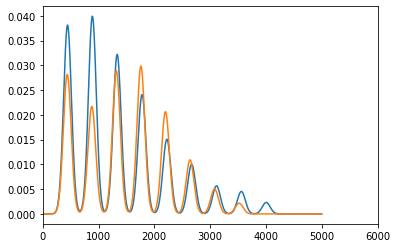

Pass 1, new penalty function: 88.226


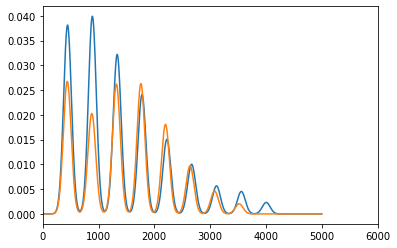

-----> {'amplitude': 0.1024813301378316, 'harm': 0, 'multiplier': 1, 'index': 0.2861293902881674}
-----> {'amplitude': 0.10419845438750965, 'harm': 1, 'multiplier': 1, 'index': 4.236184722765823}
-----> {'amplitude': 0.1805208964735728, 'harm': 2, 'multiplier': 1, 'index': 2.1113683636946816}
-----> {'amplitude': 0.2, 'harm': 3, 'multiplier': 1, 'index': 2.1204654757502124}
-----> {'amplitude': 0.12103041272165728, 'harm': 4, 'multiplier': 1, 'index': 4.495514955803608}
Pass 2, new penalty function: 88.015


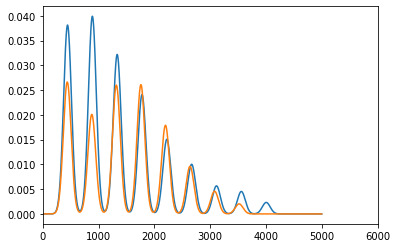

-----> {'amplitude': 0.1024813301378316, 'harm': 0, 'multiplier': 1, 'index': 0.2861293902881674}
-----> {'amplitude': 0.10248667920979702, 'harm': 1, 'multiplier': 1, 'index': 4.236184722765823}
-----> {'amplitude': 0.1805208964735728, 'harm': 2, 'multiplier': 1, 'index': 2.1113683636946816}
-----> {'amplitude': 0.1961295019457435, 'harm': 3, 'multiplier': 1, 'index': 2.1034214696051543}
-----> {'amplitude': 0.12103041272165728, 'harm': 4, 'multiplier': 1, 'index': 4.487139109457075}
Pass 3, new penalty function: 87.058


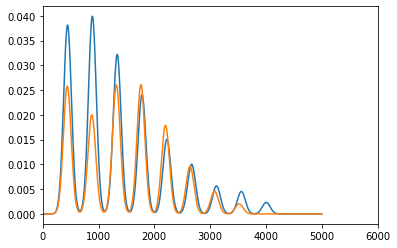

-----> {'amplitude': 0.09721268722804448, 'harm': 0, 'multiplier': 1, 'index': 0.2861293902881674}
-----> {'amplitude': 0.10248667920979702, 'harm': 1, 'multiplier': 1, 'index': 4.228142914360649}
-----> {'amplitude': 0.1805208964735728, 'harm': 2, 'multiplier': 1, 'index': 2.0970481357718933}
-----> {'amplitude': 0.1961295019457435, 'harm': 3, 'multiplier': 1, 'index': 2.1034214696051543}
-----> {'amplitude': 0.12103041272165728, 'harm': 4, 'multiplier': 1, 'index': 4.487139109457075}
Pass 4, new penalty function: 86.805


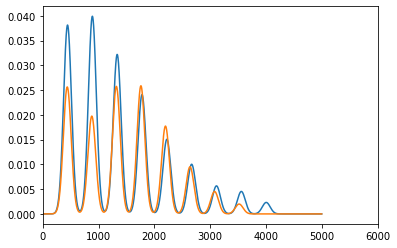

-----> {'amplitude': 0.09721268722804448, 'harm': 0, 'multiplier': 1, 'index': 0.2861293902881674}
-----> {'amplitude': 0.10079007688356434, 'harm': 1, 'multiplier': 1, 'index': 4.228142914360649}
-----> {'amplitude': 0.17725134037627396, 'harm': 2, 'multiplier': 1, 'index': 2.0970481357718933}
-----> {'amplitude': 0.1961295019457435, 'harm': 3, 'multiplier': 1, 'index': 2.1034214696051543}
-----> {'amplitude': 0.11925234097723314, 'harm': 4, 'multiplier': 1, 'index': 4.478760037138303}
Pass 5, new penalty function: 85.935


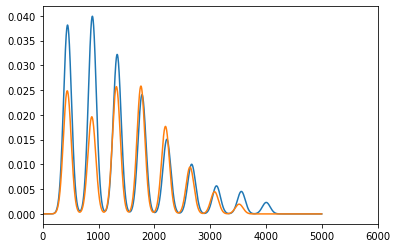

-----> {'amplitude': 0.09228305456152558, 'harm': 0, 'multiplier': 1, 'index': 0.2861293902881674}
-----> {'amplitude': 0.10079007688356434, 'harm': 1, 'multiplier': 1, 'index': 4.228142914360649}
-----> {'amplitude': 0.17725134037627396, 'harm': 2, 'multiplier': 1, 'index': 2.0970481357718933}
-----> {'amplitude': 0.1961295019457435, 'harm': 3, 'multiplier': 1, 'index': 2.1034214696051543}
-----> {'amplitude': 0.11748973464235127, 'harm': 4, 'multiplier': 1, 'index': 4.470444484543231}
Pass 6, new penalty function: 85.304


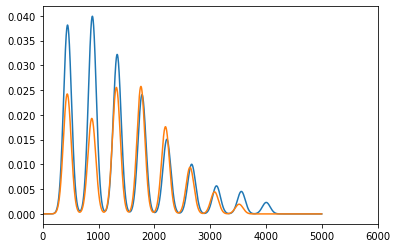

-----> {'amplitude': 0.0876552081866622, 'harm': 0, 'multiplier': 1, 'index': 0.2693486495014629}
-----> {'amplitude': 0.10079007688356434, 'harm': 1, 'multiplier': 1, 'index': 4.220159045185701}
-----> {'amplitude': 0.17407057361894157, 'harm': 2, 'multiplier': 1, 'index': 2.0830709540782797}
-----> {'amplitude': 0.1961295019457435, 'harm': 3, 'multiplier': 1, 'index': 2.0868435692510747}
-----> {'amplitude': 0.11748973464235128, 'harm': 4, 'multiplier': 1, 'index': 4.462190025042173}
Pass 7, new penalty function: 84.537


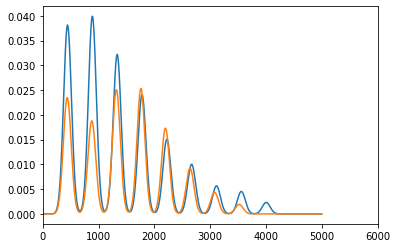

-----> {'amplitude': 0.08321152879048763, 'harm': 0, 'multiplier': 1, 'index': 0.25324522658318177}
-----> {'amplitude': 0.09910806618253348, 'harm': 1, 'multiplier': 1, 'index': 4.220159045185701}
-----> {'amplitude': 0.17096328269562228, 'harm': 2, 'multiplier': 1, 'index': 2.0830709540782797}
-----> {'amplitude': 0.1923475875619706, 'harm': 3, 'multiplier': 1, 'index': 2.070206274425254}
-----> {'amplitude': 0.11574128398115474, 'harm': 4, 'multiplier': 1, 'index': 4.453932565276419}
Pass 8, new penalty function: 83.889


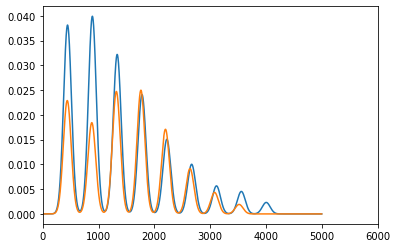

-----> {'amplitude': 0.07894290687529855, 'harm': 0, 'multiplier': 1, 'index': 0.23777447697364987}
-----> {'amplitude': 0.09910806618253348, 'harm': 1, 'multiplier': 1, 'index': 4.2122304308786935}
-----> {'amplitude': 0.16793672635141696, 'harm': 2, 'multiplier': 1, 'index': 2.0830709540782797}
-----> {'amplitude': 0.18866589146204665, 'harm': 3, 'multiplier': 1, 'index': 2.070206274425254}
-----> {'amplitude': 0.11574128398115476, 'harm': 4, 'multiplier': 1, 'index': 4.453932565276419}
Pass 9, new penalty function: 83.101


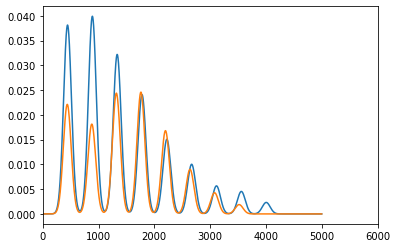

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.2377744769736499}
-----> {'amplitude': 0.09910806618253348, 'harm': 1, 'multiplier': 1, 'index': 4.2122304308786935}
-----> {'amplitude': 0.16498691040315175, 'harm': 2, 'multiplier': 1, 'index': 2.07009863193316}
-----> {'amplitude': 0.1850942694970585, 'harm': 3, 'multiplier': 1, 'index': 2.070206274425254}
-----> {'amplitude': 0.11400731758062334, 'harm': 4, 'multiplier': 1, 'index': 4.445733953267337}
Pass 10, new penalty function: 83.32


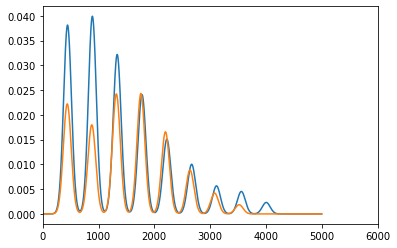

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.22360422757682816}
-----> {'amplitude': 0.09910806618253348, 'harm': 1, 'multiplier': 1, 'index': 4.204300627468875}
-----> {'amplitude': 0.16498691040315175, 'harm': 2, 'multiplier': 1, 'index': 2.0574072752054096}
-----> {'amplitude': 0.18162679132499168, 'harm': 3, 'multiplier': 1, 'index': 2.070206274425254}
-----> {'amplitude': 0.11228734887032535, 'harm': 4, 'multiplier': 1, 'index': 4.445733953267337}
Pass 11, new penalty function: 83.479


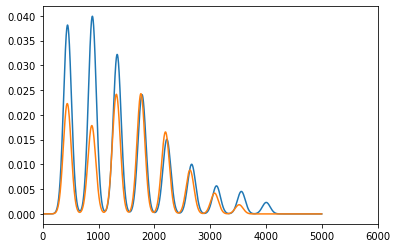

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.20928261699539594}
-----> {'amplitude': 0.097439752886618, 'harm': 1, 'multiplier': 1, 'index': 4.196369632093499}
-----> {'amplitude': 0.16498691040315175, 'harm': 2, 'multiplier': 1, 'index': 2.0574072752054096}
-----> {'amplitude': 0.18162679132499168, 'harm': 3, 'multiplier': 1, 'index': 2.070206274425254}
-----> {'amplitude': 0.11228734887032535, 'harm': 4, 'multiplier': 1, 'index': 4.445733953267337}
Pass 12, new penalty function: 83.648


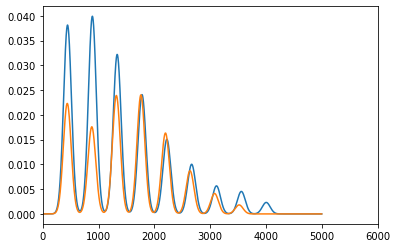

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.19480262835998693}
-----> {'amplitude': 0.0957849292766899, 'harm': 1, 'multiplier': 1, 'index': 4.1884913933145995}
-----> {'amplitude': 0.16498691040315175, 'harm': 2, 'multiplier': 1, 'index': 2.0574072752054096}
-----> {'amplitude': 0.1782579335070247, 'harm': 3, 'multiplier': 1, 'index': 2.0553815398913713}
-----> {'amplitude': 0.11058162758590434, 'harm': 4, 'multiplier': 1, 'index': 4.437648852931601}
Pass 13, new penalty function: 83.84


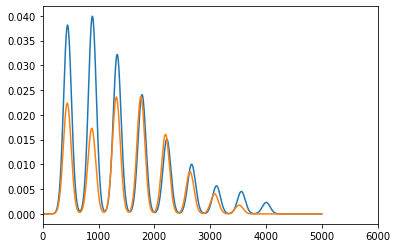

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.1801592624026913}
-----> {'amplitude': 0.0957849292766899, 'harm': 1, 'multiplier': 1, 'index': 4.1884913933145995}
-----> {'amplitude': 0.1620918380871093, 'harm': 2, 'multiplier': 1, 'index': 2.044683827066037}
-----> {'amplitude': 0.17497091712129856, 'harm': 3, 'multiplier': 1, 'index': 2.0409186353765008}
-----> {'amplitude': 0.10888894071956494, 'harm': 4, 'multiplier': 1, 'index': 4.437648852931601}
Pass 14, new penalty function: 83.742


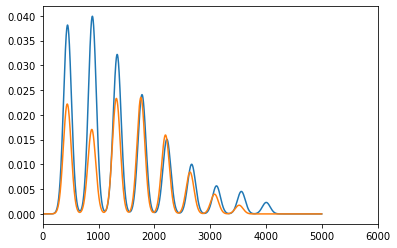

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.1801592624026913}
-----> {'amplitude': 0.09414305970232648, 'harm': 1, 'multiplier': 1, 'index': 4.1884913933145995}
-----> {'amplitude': 0.15925837746226618, 'harm': 2, 'multiplier': 1, 'index': 2.044683827066037}
-----> {'amplitude': 0.17497091712129856, 'harm': 3, 'multiplier': 1, 'index': 2.0268012449855735}
-----> {'amplitude': 0.10720950940309938, 'harm': 4, 'multiplier': 1, 'index': 4.429668037079771}
Pass 15, new penalty function: 83.694


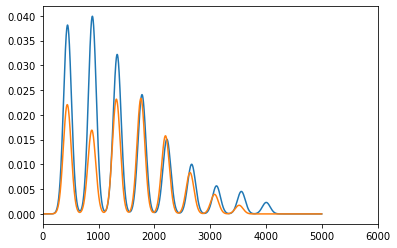

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.1801592624026913}
-----> {'amplitude': 0.09251391070733618, 'harm': 1, 'multiplier': 1, 'index': 4.1884913933145995}
-----> {'amplitude': 0.15925837746226618, 'harm': 2, 'multiplier': 1, 'index': 2.0325192003034993}
-----> {'amplitude': 0.1717513690838776, 'harm': 3, 'multiplier': 1, 'index': 2.012642720565987}
-----> {'amplitude': 0.10720950940309938, 'harm': 4, 'multiplier': 1, 'index': 4.429668037079771}
Pass 16, new penalty function: 83.947


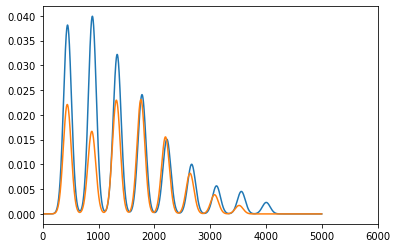

-----> {'amplitude': 0.07484059207355974, 'harm': 0, 'multiplier': 1, 'index': 0.16534173297814583}
-----> {'amplitude': 0.09089694581931389, 'harm': 1, 'multiplier': 1, 'index': 4.180758317332851}
-----> {'amplitude': 0.15925837746226618, 'harm': 2, 'multiplier': 1, 'index': 2.0203253013390317}
-----> {'amplitude': 0.16860745324023163, 'harm': 3, 'multiplier': 1, 'index': 1.998816612988968}
-----> {'amplitude': 0.10554219685814295, 'harm': 4, 'multiplier': 1, 'index': 4.421734857545507}
Pass 17, new penalty function: 83.428


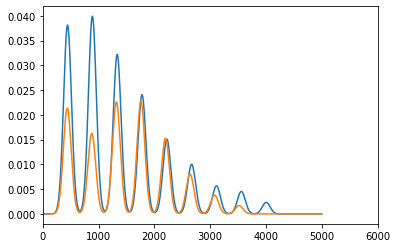

-----> {'amplitude': 0.07061371185112623, 'harm': 0, 'multiplier': 1, 'index': 0.15034145657206255}
-----> {'amplitude': 0.08929138156071477, 'harm': 1, 'multiplier': 1, 'index': 4.180758317332851}
-----> {'amplitude': 0.15647572604601215, 'harm': 2, 'multiplier': 1, 'index': 2.008101662216639}
-----> {'amplitude': 0.16553601431445203, 'harm': 3, 'multiplier': 1, 'index': 1.9853081114921918}
-----> {'amplitude': 0.10388657337823169, 'harm': 4, 'multiplier': 1, 'index': 4.413847269355103}
Pass 18, new penalty function: 83.44


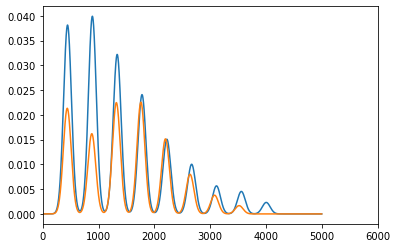

-----> {'amplitude': 0.07061371185112623, 'harm': 0, 'multiplier': 1, 'index': 0.15034145657206255}
-----> {'amplitude': 0.08929138156071477, 'harm': 1, 'multiplier': 1, 'index': 4.173109441982206}
-----> {'amplitude': 0.15647572604601215, 'harm': 2, 'multiplier': 1, 'index': 2.008101662216639}
-----> {'amplitude': 0.16253405458454814, 'harm': 3, 'multiplier': 1, 'index': 1.985308111492192}
-----> {'amplitude': 0.10388657337823169, 'harm': 4, 'multiplier': 1, 'index': 4.406003271889975}
Pass 19, new penalty function: 83.422


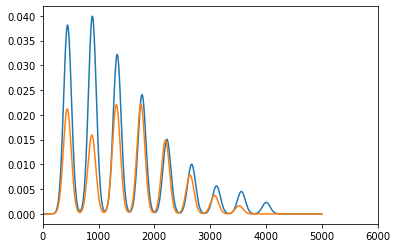

-----> {'amplitude': 0.07061371185112623, 'harm': 0, 'multiplier': 1, 'index': 0.15034145657206255}
-----> {'amplitude': 0.08769673559326303, 'harm': 1, 'multiplier': 1, 'index': 4.173109441982206}
-----> {'amplitude': 0.15375015152082508, 'harm': 2, 'multiplier': 1, 'index': 2.008101662216639}
-----> {'amplitude': 0.1596078702174766, 'harm': 3, 'multiplier': 1, 'index': 1.985308111492192}
-----> {'amplitude': 0.10224161771186444, 'harm': 4, 'multiplier': 1, 'index': 4.398157088283612}
Pass 20, new penalty function: 83.0


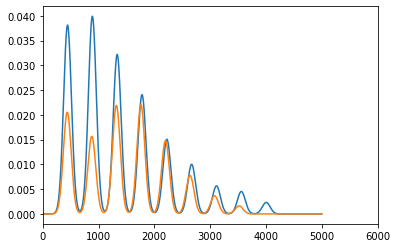

-----> {'amplitude': 0.06656364705959049, 'harm': 0, 'multiplier': 1, 'index': 0.13593775597955224}
-----> {'amplitude': 0.08769673559326303, 'harm': 1, 'multiplier': 1, 'index': 4.173109441982206}
-----> {'amplitude': 0.15108739055347192, 'harm': 2, 'multiplier': 1, 'index': 1.9963926586428575}
-----> {'amplitude': 0.1596078702174766, 'harm': 3, 'multiplier': 1, 'index': 1.972734852125725}
-----> {'amplitude': 0.10060754159836911, 'harm': 4, 'multiplier': 1, 'index': 4.390352626426538}
Pass 21, new penalty function: 82.614


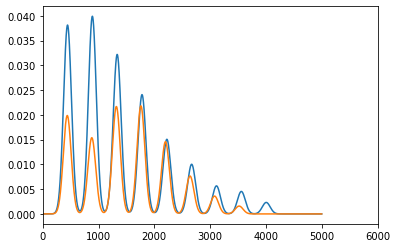

-----> {'amplitude': 0.06268087046510183, 'harm': 0, 'multiplier': 1, 'index': 0.12208769431942285}
-----> {'amplitude': 0.08611326774287269, 'harm': 1, 'multiplier': 1, 'index': 4.165501222021431}
-----> {'amplitude': 0.15108739055347192, 'harm': 2, 'multiplier': 1, 'index': 1.9963926586428575}
-----> {'amplitude': 0.15674536126910815, 'harm': 3, 'multiplier': 1, 'index': 1.9601304971017723}
-----> {'amplitude': 0.0989839419714989, 'harm': 4, 'multiplier': 1, 'index': 4.382587964915871}
Pass 22, new penalty function: 82.629


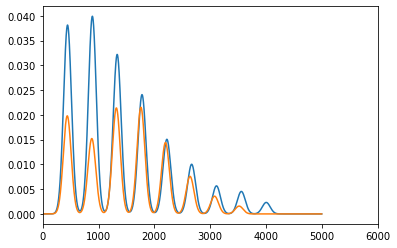

-----> {'amplitude': 0.06268087046510183, 'harm': 0, 'multiplier': 1, 'index': 0.12208769431942285}
-----> {'amplitude': 0.08611326774287269, 'harm': 1, 'multiplier': 1, 'index': 4.165501222021431}
-----> {'amplitude': 0.1484769265496703, 'harm': 2, 'multiplier': 1, 'index': 1.9963926586428575}
-----> {'amplitude': 0.15394375435053284, 'harm': 3, 'multiplier': 1, 'index': 1.9601304971017723}
-----> {'amplitude': 0.0989839419714989, 'harm': 4, 'multiplier': 1, 'index': 4.382587964915871}
Pass 23, new penalty function: 82.041


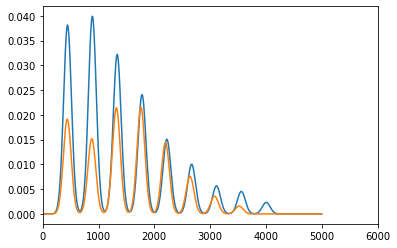

-----> {'amplitude': 0.05895623558591389, 'harm': 0, 'multiplier': 1, 'index': 0.12208769431942285}
-----> {'amplitude': 0.08611326774287269, 'harm': 1, 'multiplier': 1, 'index': 4.157928885476902}
-----> {'amplitude': 0.1484769265496703, 'harm': 2, 'multiplier': 1, 'index': 1.985151892113885}
-----> {'amplitude': 0.15394375435053284, 'harm': 3, 'multiplier': 1, 'index': 1.9601304971017723}
-----> {'amplitude': 0.0989839419714989, 'harm': 4, 'multiplier': 1, 'index': 4.374861220758836}
Pass 24, new penalty function: 81.659


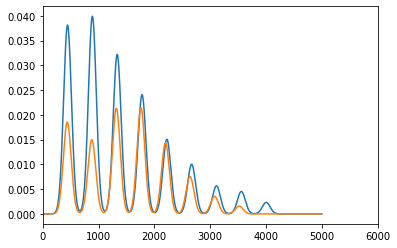

-----> {'amplitude': 0.055436303718139776, 'harm': 0, 'multiplier': 1, 'index': 0.10934990056802384}
-----> {'amplitude': 0.08611326774287269, 'harm': 1, 'multiplier': 1, 'index': 4.150355763919592}
-----> {'amplitude': 0.14591685529976495, 'harm': 2, 'multiplier': 1, 'index': 1.973886622447973}
-----> {'amplitude': 0.15394375435053284, 'harm': 3, 'multiplier': 1, 'index': 1.9480706487726576}
-----> {'amplitude': 0.0989839419714989, 'harm': 4, 'multiplier': 1, 'index': 4.374861220758836}
Pass 25, new penalty function: 81.182


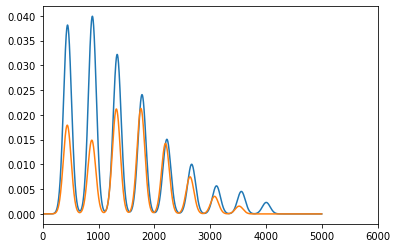

-----> {'amplitude': 0.05205165045603679, 'harm': 0, 'multiplier': 1, 'index': 0.10934990056802385}
-----> {'amplitude': 0.08611326774287269, 'harm': 1, 'multiplier': 1, 'index': 4.150355763919592}
-----> {'amplitude': 0.14591685529976495, 'harm': 2, 'multiplier': 1, 'index': 1.9738866224479732}
-----> {'amplitude': 0.15120079197957756, 'harm': 3, 'multiplier': 1, 'index': 1.9480706487726576}
-----> {'amplitude': 0.0989839419714989, 'harm': 4, 'multiplier': 1, 'index': 4.374861220758836}
Pass 26, new penalty function: 80.92


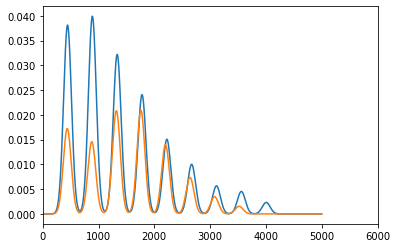

-----> {'amplitude': 0.0488383203803983, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.08453929081681315, 'harm': 1, 'multiplier': 1, 'index': 4.142781855824878}
-----> {'amplitude': 0.14340505172411014, 'harm': 2, 'multiplier': 1, 'index': 1.9628288594531582}
-----> {'amplitude': 0.14852138020029643, 'harm': 3, 'multiplier': 1, 'index': 1.9480706487726576}
-----> {'amplitude': 0.0973698812555329, 'harm': 4, 'multiplier': 1, 'index': 4.374861220758836}
Pass 27, new penalty function: 80.924


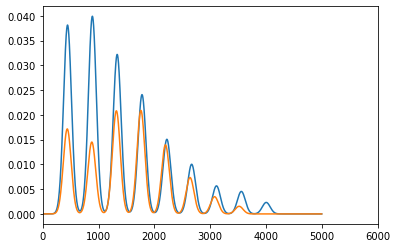

-----> {'amplitude': 0.0488383203803983, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.08297483380551225, 'harm': 1, 'multiplier': 1, 'index': 4.135241766760195}
-----> {'amplitude': 0.14340505172411014, 'harm': 2, 'multiplier': 1, 'index': 1.9519697954392943}
-----> {'amplitude': 0.14852138020029643, 'harm': 3, 'multiplier': 1, 'index': 1.9480706487726576}
-----> {'amplitude': 0.0973698812555329, 'harm': 4, 'multiplier': 1, 'index': 4.367170559983489}
Pass 28, new penalty function: 81.06


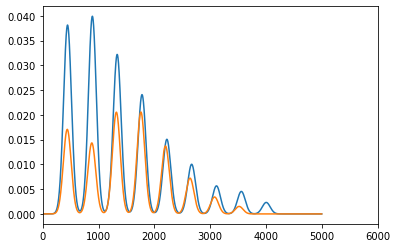

-----> {'amplitude': 0.0488383203803983, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.08297483380551225, 'harm': 1, 'multiplier': 1, 'index': 4.135241766760195}
-----> {'amplitude': 0.14093343651604806, 'harm': 2, 'multiplier': 1, 'index': 1.941087915633045}
-----> {'amplitude': 0.14590251667708368, 'harm': 3, 'multiplier': 1, 'index': 1.9480706487726576}
-----> {'amplitude': 0.09576553786663149, 'harm': 4, 'multiplier': 1, 'index': 4.359478030636386}
Pass 29, new penalty function: 81.142


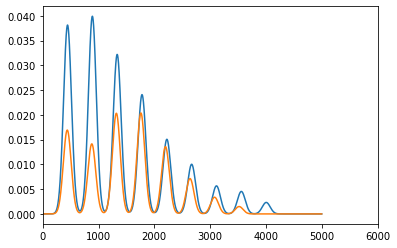

-----> {'amplitude': 0.0488383203803983, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.0814194545709027, 'harm': 1, 'multiplier': 1, 'index': 4.127733379295659}
-----> {'amplitude': 0.13850664059342319, 'harm': 2, 'multiplier': 1, 'index': 1.9303973663505551}
-----> {'amplitude': 0.14590251667708368, 'harm': 3, 'multiplier': 1, 'index': 1.9480706487726576}
-----> {'amplitude': 0.09417052919273229, 'harm': 4, 'multiplier': 1, 'index': 4.359478030636386}
Pass 30, new penalty function: 80.831


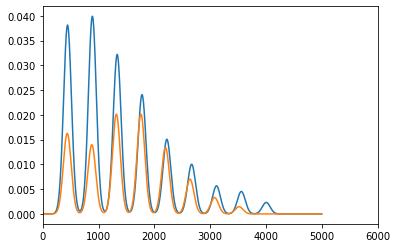

-----> {'amplitude': 0.04574901941134129, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.07987271983162779, 'harm': 1, 'multiplier': 1, 'index': 4.120254616349605}
-----> {'amplitude': 0.13850664059342319, 'harm': 2, 'multiplier': 1, 'index': 1.9303973663505551}
-----> {'amplitude': 0.14334137200497457, 'harm': 3, 'multiplier': 1, 'index': 1.9367488509797397}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.359478030636386}
Pass 31, new penalty function: 80.448


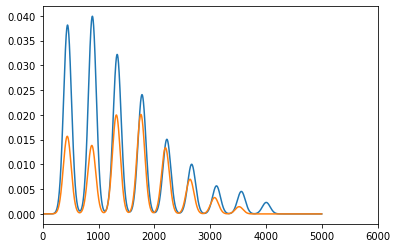

-----> {'amplitude': 0.04280260566498925, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.07987271983162779, 'harm': 1, 'multiplier': 1, 'index': 4.120254616349605}
-----> {'amplitude': 0.13612294049002774, 'harm': 2, 'multiplier': 1, 'index': 1.9303973663505551}
-----> {'amplitude': 0.14334137200497457, 'harm': 3, 'multiplier': 1, 'index': 1.9256349274650588}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.351886502740767}
Pass 32, new penalty function: 80.125


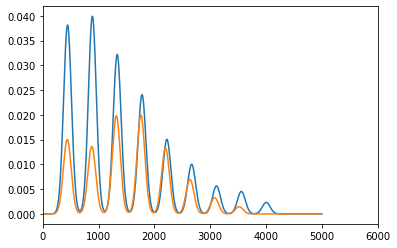

-----> {'amplitude': 0.039985098485307694, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07833420466062783, 'harm': 1, 'multiplier': 1, 'index': 4.120254616349605}
-----> {'amplitude': 0.13378679637829166, 'harm': 2, 'multiplier': 1, 'index': 1.920086051633742}
-----> {'amplitude': 0.14334137200497457, 'harm': 3, 'multiplier': 1, 'index': 1.9256349274650588}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.351886502740767}
Pass 33, new penalty function: 79.891


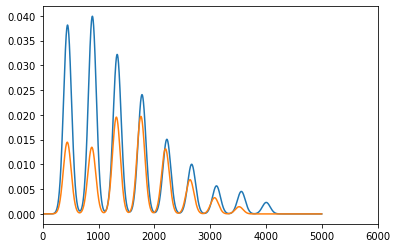

-----> {'amplitude': 0.03728412632592697, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.07833420466062783, 'harm': 1, 'multiplier': 1, 'index': 4.120254616349605}
-----> {'amplitude': 0.1314902905432797, 'harm': 2, 'multiplier': 1, 'index': 1.920086051633742}
-----> {'amplitude': 0.1408177064171393, 'harm': 3, 'multiplier': 1, 'index': 1.9256349274650588}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.344293331899865}
Pass 34, new penalty function: 79.684


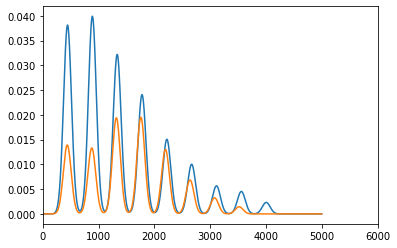

-----> {'amplitude': 0.034688690573122447, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.07680366949105095, 'harm': 1, 'multiplier': 1, 'index': 4.120254616349605}
-----> {'amplitude': 0.1314902905432797, 'harm': 2, 'multiplier': 1, 'index': 1.9101205852688776}
-----> {'amplitude': 0.13834746975390375, 'harm': 3, 'multiplier': 1, 'index': 1.9256349274650588}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.336698511055542}
Pass 35, new penalty function: 79.528


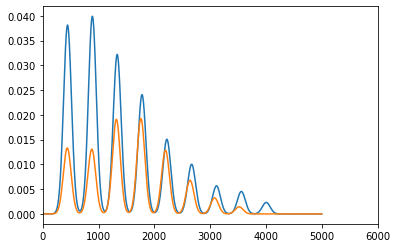

-----> {'amplitude': 0.03218896928723316, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07528068523093046, 'harm': 1, 'multiplier': 1, 'index': 4.120254616349605}
-----> {'amplitude': 0.12923202061122985, 'harm': 2, 'multiplier': 1, 'index': 1.9101205852688776}
-----> {'amplitude': 0.13592822379927944, 'harm': 3, 'multiplier': 1, 'index': 1.9149326598418517}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.329102033110723}
Pass 36, new penalty function: 79.264


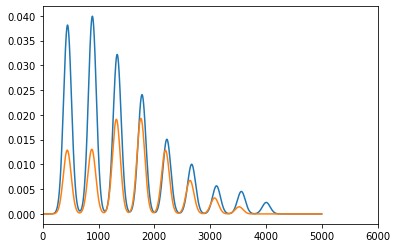

-----> {'amplitude': 0.02977615312276365, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07528068523093046, 'harm': 1, 'multiplier': 1, 'index': 4.112875824704334}
-----> {'amplitude': 0.12923202061122985, 'harm': 2, 'multiplier': 1, 'index': 1.9101205852688776}
-----> {'amplitude': 0.13592822379927944, 'harm': 3, 'multiplier': 1, 'index': 1.9044124303067775}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.329102033110723}
Pass 37, new penalty function: 79.179


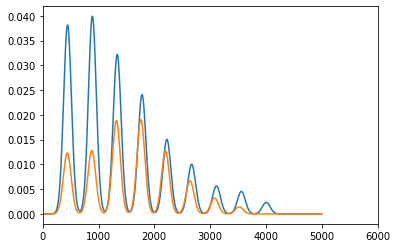

-----> {'amplitude': 0.027442307355890785, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07376467292133822, 'harm': 1, 'multiplier': 1, 'index': 4.112875824704334}
-----> {'amplitude': 0.12701583093880348, 'harm': 2, 'multiplier': 1, 'index': 1.9003080571416648}
-----> {'amplitude': 0.13354716208434278, 'harm': 3, 'multiplier': 1, 'index': 1.8938731646286218}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.329102033110723}
Pass 38, new penalty function: 79.273


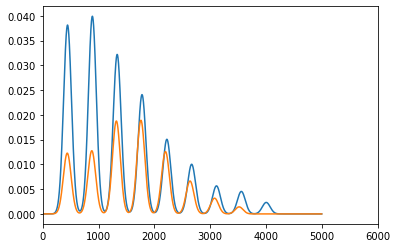

-----> {'amplitude': 0.02744230735589078, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.07376467292133822, 'harm': 1, 'multiplier': 1, 'index': 4.112875824704334}
-----> {'amplitude': 0.12701583093880348, 'harm': 2, 'multiplier': 1, 'index': 1.8906440219901166}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.883509300735305}
-----> {'amplitude': 0.09258497215643162, 'harm': 4, 'multiplier': 1, 'index': 4.321503890929111}
Pass 39, new penalty function: 79.141


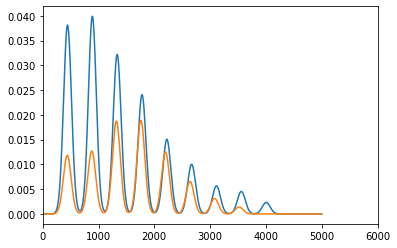

-----> {'amplitude': 0.02518025522096122, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07376467292133822, 'harm': 1, 'multiplier': 1, 'index': 4.105516692246125}
-----> {'amplitude': 0.12701583093880348, 'harm': 2, 'multiplier': 1, 'index': 1.8809631140811747}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8732865656195181}
-----> {'amplitude': 0.0910061028529227, 'harm': 4, 'multiplier': 1, 'index': 4.313904077334902}
Pass 40, new penalty function: 78.974


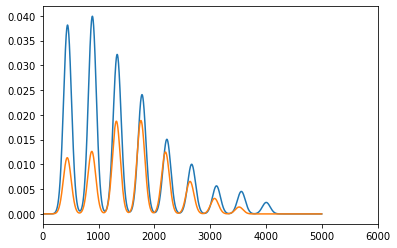

-----> {'amplitude': 0.02298347873651911, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07225523692492261, 'harm': 1, 'multiplier': 1, 'index': 4.105516692246125}
-----> {'amplitude': 0.12701583093880348, 'harm': 2, 'multiplier': 1, 'index': 1.871265099323708}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8732865656195183}
-----> {'amplitude': 0.0910061028529227, 'harm': 4, 'multiplier': 1, 'index': 4.306333561625338}
Pass 41, new penalty function: 78.974


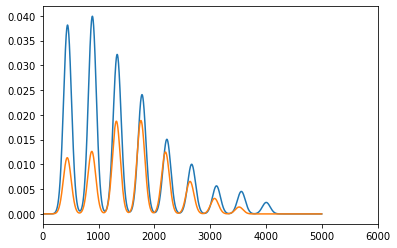

-----> {'amplitude': 0.02298347873651911, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07225523692492261, 'harm': 1, 'multiplier': 1, 'index': 4.105516692246125}
-----> {'amplitude': 0.12701583093880348, 'harm': 2, 'multiplier': 1, 'index': 1.8712650993237083}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8732865656195183}
-----> {'amplitude': 0.0910061028529227, 'harm': 4, 'multiplier': 1, 'index': 4.306333561625338}
Pass 42, new penalty function: 78.93


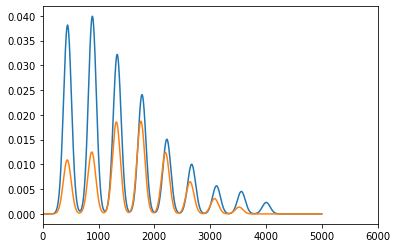

-----> {'amplitude': 0.020846033960047652, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.07225523692492261, 'harm': 1, 'multiplier': 1, 'index': 4.105516692246125}
-----> {'amplitude': 0.12481921511366201, 'harm': 2, 'multiplier': 1, 'index': 1.8615497389712092}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8732865656195183}
-----> {'amplitude': 0.08943506234021692, 'harm': 4, 'multiplier': 1, 'index': 4.298761436660037}
Pass 43, new penalty function: 78.863


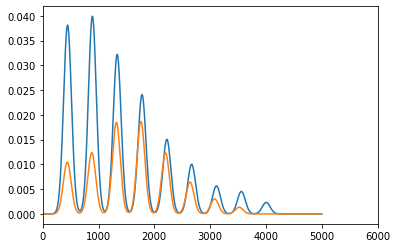

-----> {'amplitude': 0.018762478202715323, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.07075212843743682, 'harm': 1, 'multiplier': 1, 'index': 4.098175339601481}
-----> {'amplitude': 0.12481921511366202, 'harm': 2, 'multiplier': 1, 'index': 1.8615497389712095}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.863046638933761}
-----> {'amplitude': 0.08787197403752726, 'harm': 4, 'multiplier': 1, 'index': 4.291216978945232}
Pass 44, new penalty function: 78.897


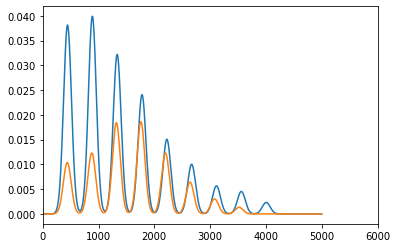

-----> {'amplitude': 0.018762478202715323, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06925481410354405, 'harm': 1, 'multiplier': 1, 'index': 4.090849910779505}
-----> {'amplitude': 0.12481921511366202, 'harm': 2, 'multiplier': 1, 'index': 1.8615497389712095}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.863046638933761}
-----> {'amplitude': 0.08787197403752726, 'harm': 4, 'multiplier': 1, 'index': 4.283698512564837}
Pass 45, new penalty function: 78.728


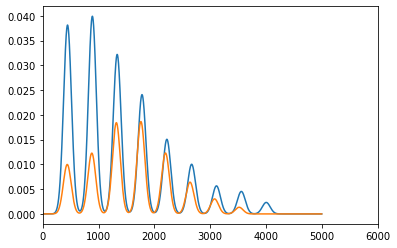

-----> {'amplitude': 0.016727807200630523, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06925481410354405, 'harm': 1, 'multiplier': 1, 'index': 4.090849910779505}
-----> {'amplitude': 0.12481921511366202, 'harm': 2, 'multiplier': 1, 'index': 1.8615497389712095}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8527893462606686}
-----> {'amplitude': 0.08787197403752726, 'harm': 4, 'multiplier': 1, 'index': 4.283698512564837}
Pass 46, new penalty function: 78.625


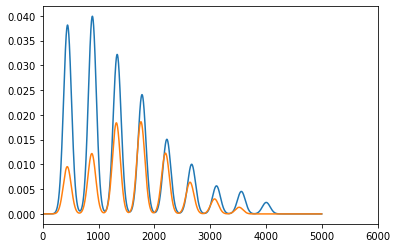

-----> {'amplitude': 0.014737400606898354, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06776291562808316, 'harm': 1, 'multiplier': 1, 'index': 4.083538574534501}
-----> {'amplitude': 0.12481921511366202, 'harm': 2, 'multiplier': 1, 'index': 1.85197649410538}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8527893462606688}
-----> {'amplitude': 0.08787197403752726, 'harm': 4, 'multiplier': 1, 'index': 4.276178562805922}
Pass 47, new penalty function: 78.576


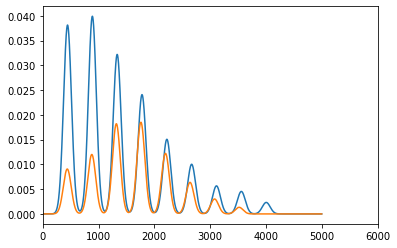

-----> {'amplitude': 0.012786974461225844, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06627605956343272, 'harm': 1, 'multiplier': 1, 'index': 4.076239520570056}
-----> {'amplitude': 0.1226518192207621, 'harm': 2, 'multiplier': 1, 'index': 1.85197649410538}
-----> {'amplitude': 0.1312081076228375, 'harm': 3, 'multiplier': 1, 'index': 1.8425145104253327}
-----> {'amplitude': 0.08787197403752726, 'harm': 4, 'multiplier': 1, 'index': 4.26865712318048}
Pass 48, new penalty function: 78.607


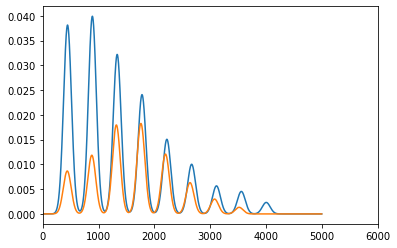

-----> {'amplitude': 0.010872539527611698, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06627605956343272, 'harm': 1, 'multiplier': 1, 'index': 4.068950957686976}
-----> {'amplitude': 0.12052273854421773, 'harm': 2, 'multiplier': 1, 'index': 1.85197649410538}
-----> {'amplitude': 0.12888979083876964, 'harm': 3, 'multiplier': 1, 'index': 1.8425145104253329}
-----> {'amplitude': 0.08787197403752726, 'harm': 4, 'multiplier': 1, 'index': 4.26865712318048}
Pass 49, new penalty function: 78.637


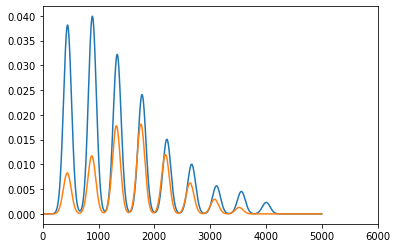

-----> {'amplitude': 0.00896478400542719, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.06627605956343272, 'harm': 1, 'multiplier': 1, 'index': 4.068950957686976}
-----> {'amplitude': 0.11843030163664568, 'harm': 2, 'multiplier': 1, 'index': 1.85197649410538}
-----> {'amplitude': 0.12888979083876964, 'harm': 3, 'multiplier': 1, 'index': 1.8425145104253329}
-----> {'amplitude': 0.08631519283303347, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 50, new penalty function: 78.68


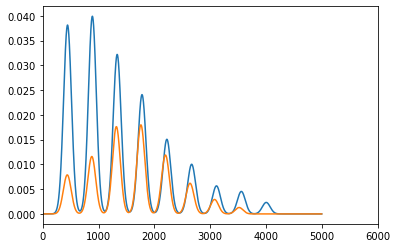

-----> {'amplitude': 0.007088454102512569, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.06627605956343272, 'harm': 1, 'multiplier': 1, 'index': 4.061662077351763}
-----> {'amplitude': 0.11637291786331785, 'harm': 2, 'multiplier': 1, 'index': 1.85197649410538}
-----> {'amplitude': 0.12888979083876964, 'harm': 3, 'multiplier': 1, 'index': 1.8425145104253329}
-----> {'amplitude': 0.08476571984299075, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 51, new penalty function: 78.728


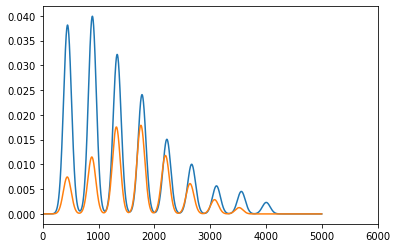

-----> {'amplitude': 0.005240096259480749, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.064793657355915, 'harm': 1, 'multiplier': 1, 'index': 4.054372879256278}
-----> {'amplitude': 0.11637291786331787, 'harm': 2, 'multiplier': 1, 'index': 1.84295665723446}
-----> {'amplitude': 0.12888979083876964, 'harm': 3, 'multiplier': 1, 'index': 1.8425145104253329}
-----> {'amplitude': 0.08322361871883538, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 52, new penalty function: 78.926


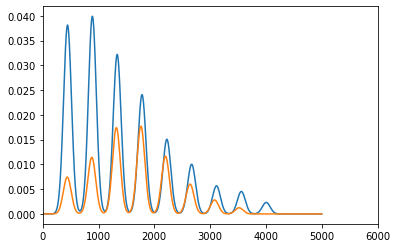

-----> {'amplitude': 0.005240096259480749, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.064793657355915, 'harm': 1, 'multiplier': 1, 'index': 4.054372879256278}
-----> {'amplitude': 0.11637291786331787, 'harm': 2, 'multiplier': 1, 'index': 1.84295665723446}
-----> {'amplitude': 0.12661612574017747, 'harm': 3, 'multiplier': 1, 'index': 1.8324044762934761}
-----> {'amplitude': 0.08168742525997702, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 53, new penalty function: 78.988


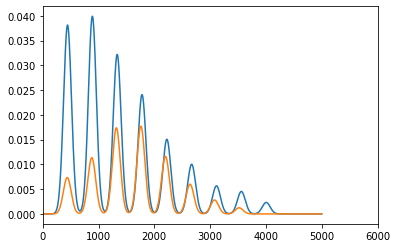

-----> {'amplitude': 0.005240096259480749, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.06331557841563973, 'harm': 1, 'multiplier': 1, 'index': 4.047092453775713}
-----> {'amplitude': 0.11637291786331787, 'harm': 2, 'multiplier': 1, 'index': 1.8339229676671212}
-----> {'amplitude': 0.12661612574017747, 'harm': 3, 'multiplier': 1, 'index': 1.8224519292928085}
-----> {'amplitude': 0.08168742525997702, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 54, new penalty function: 78.961


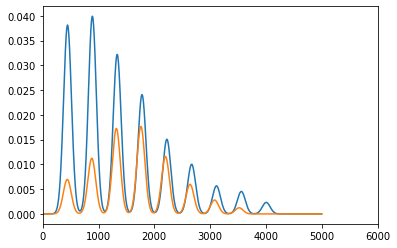

-----> {'amplitude': 0.0034164467387742753, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06331557841563973, 'harm': 1, 'multiplier': 1, 'index': 4.039819040165919}
-----> {'amplitude': 0.1143404163080778, 'harm': 2, 'multiplier': 1, 'index': 1.8339229676671212}
-----> {'amplitude': 0.12661612574017747, 'harm': 3, 'multiplier': 1, 'index': 1.812483334351183}
-----> {'amplitude': 0.08168742525997702, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 55, new penalty function: 79.133


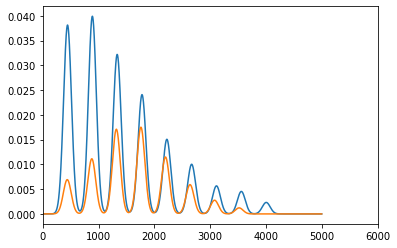

-----> {'amplitude': 0.003416446738774276, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.06331557841563973, 'harm': 1, 'multiplier': 1, 'index': 4.039819040165919}
-----> {'amplitude': 0.11234042779734003, 'harm': 2, 'multiplier': 1, 'index': 1.8339229676671212}
-----> {'amplitude': 0.12661612574017747, 'harm': 3, 'multiplier': 1, 'index': 1.8124833343511833}
-----> {'amplitude': 0.08015788979533632, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 56, new penalty function: 79.134


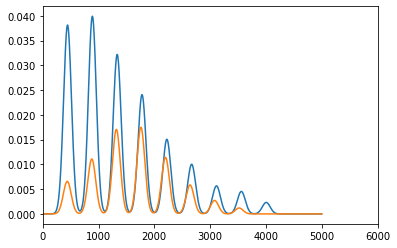

-----> {'amplitude': 0.0016144062915942228, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06331557841563973, 'harm': 1, 'multiplier': 1, 'index': 4.032545362644196}
-----> {'amplitude': 0.11234042779734003, 'harm': 2, 'multiplier': 1, 'index': 1.8339229676671212}
-----> {'amplitude': 0.12661612574017747, 'harm': 3, 'multiplier': 1, 'index': 1.8024985310700912}
-----> {'amplitude': 0.07863465679983458, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 57, new penalty function: 79.504


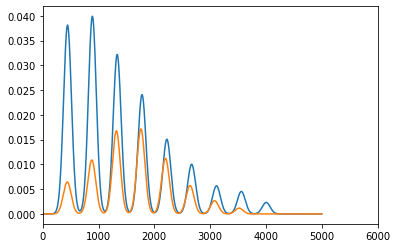

-----> {'amplitude': 0.0016144062915942232, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.06184126920845953, 'harm': 1, 'multiplier': 1, 'index': 4.032545362644196}
-----> {'amplitude': 0.11037155115639731, 'harm': 2, 'multiplier': 1, 'index': 1.8251236668948243}
-----> {'amplitude': 0.12436667457912316, 'harm': 3, 'multiplier': 1, 'index': 1.8024985310700912}
-----> {'amplitude': 0.07711737635666617, 'harm': 4, 'multiplier': 1, 'index': 4.261134187164684}
Pass 58, new penalty function: 79.516


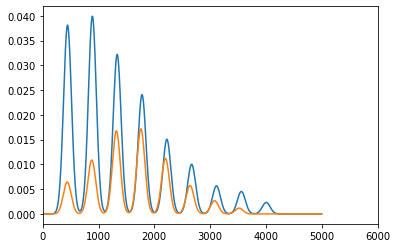

-----> {'amplitude': 0.0016144062915942232, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.061841269208459525, 'harm': 1, 'multiplier': 1, 'index': 4.032545362644196}
-----> {'amplitude': 0.11037155115639731, 'harm': 2, 'multiplier': 1, 'index': 1.8164272096182714}
-----> {'amplitude': 0.12436667457912316, 'harm': 3, 'multiplier': 1, 'index': 1.8024985310700912}
-----> {'amplitude': 0.07711737635666617, 'harm': 4, 'multiplier': 1, 'index': 4.2537507598671755}
Pass 59, new penalty function: 79.667


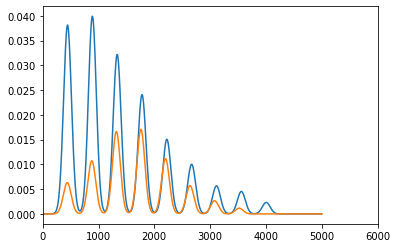

-----> {'amplitude': 0.0016144062915942232, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.06037066647509805, 'harm': 1, 'multiplier': 1, 'index': 4.032545362644196}
-----> {'amplitude': 0.1084246711040673, 'harm': 2, 'multiplier': 1, 'index': 1.8077184102580428}
-----> {'amplitude': 0.12436667457912316, 'harm': 3, 'multiplier': 1, 'index': 1.7926666452673312}
-----> {'amplitude': 0.07711737635666617, 'harm': 4, 'multiplier': 1, 'index': 4.246366279263378}
Pass 60, new penalty function: 79.988


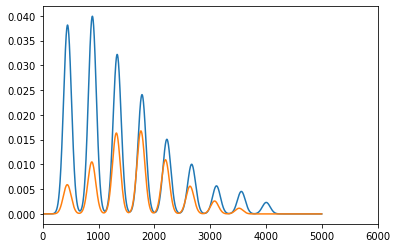

-----> {'amplitude': 0.0001, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.05890340106967134, 'harm': 1, 'multiplier': 1, 'index': 4.025280744531913}
-----> {'amplitude': 0.1065028427808702, 'harm': 2, 'multiplier': 1, 'index': 1.7991084641134591}
-----> {'amplitude': 0.12215456817100422, 'harm': 3, 'multiplier': 1, 'index': 1.7926666452673312}
-----> {'amplitude': 0.07560505781014518, 'harm': 4, 'multiplier': 1, 'index': 4.246366279263378}
Pass 61, new penalty function: 80.157


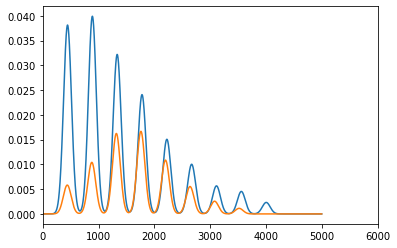

-----> {'amplitude': 0.0001, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.0574390311215939, 'harm': 1, 'multiplier': 1, 'index': 4.025280744531913}
-----> {'amplitude': 0.1065028427808702, 'harm': 2, 'multiplier': 1, 'index': 1.7991084641134591}
-----> {'amplitude': 0.12215456817100422, 'harm': 3, 'multiplier': 1, 'index': 1.7926666452673312}
-----> {'amplitude': 0.07409803686859659, 'harm': 4, 'multiplier': 1, 'index': 4.246366279263378}
Pass 62, new penalty function: 80.237


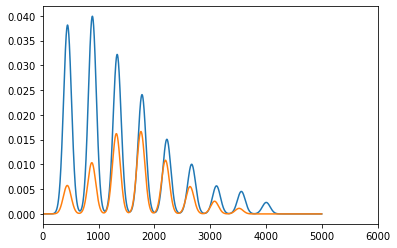

-----> {'amplitude': 9.99999999999994e-05, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.05597727642019071, 'harm': 1, 'multiplier': 1, 'index': 4.025280744531913}
-----> {'amplitude': 0.1065028427808702, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
-----> {'amplitude': 0.12215456817100422, 'harm': 3, 'multiplier': 1, 'index': 1.7926666452673312}
-----> {'amplitude': 0.07409803686859659, 'harm': 4, 'multiplier': 1, 'index': 4.239007958918586}
Pass 63, new penalty function: 80.451


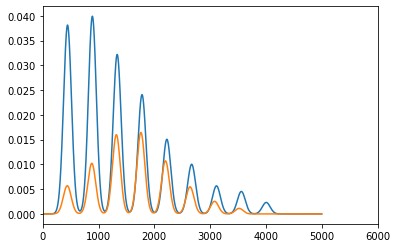

-----> {'amplitude': 0.0001, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.0559772764201907, 'harm': 1, 'multiplier': 1, 'index': 4.018016693809541}
-----> {'amplitude': 0.10460143264639785, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
-----> {'amplitude': 0.11998265755127023, 'harm': 3, 'multiplier': 1, 'index': 1.782981196074217}
-----> {'amplitude': 0.07409803686859659, 'harm': 4, 'multiplier': 1, 'index': 4.239007958918586}
Pass 64, new penalty function: 80.668


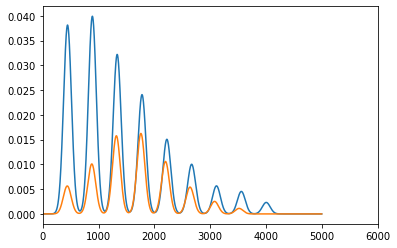

-----> {'amplitude': 9.99999999999994e-05, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.0559772764201907, 'harm': 1, 'multiplier': 1, 'index': 4.010752497594589}
-----> {'amplitude': 0.10272697332346686, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
-----> {'amplitude': 0.11784506431712317, 'harm': 3, 'multiplier': 1, 'index': 1.7734356667521873}
-----> {'amplitude': 0.07409803686859659, 'harm': 4, 'multiplier': 1, 'index': 4.231648685287778}
Pass 65, new penalty function: 80.908


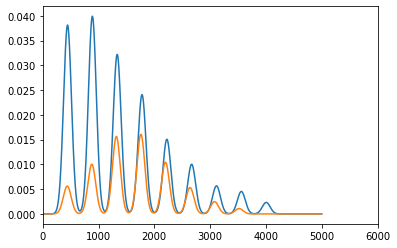

-----> {'amplitude': 9.99999999999994e-05, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.0559772764201907, 'harm': 1, 'multiplier': 1, 'index': 4.010752497594589}
-----> {'amplitude': 0.10272697332346686, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
-----> {'amplitude': 0.11574050435035589, 'harm': 3, 'multiplier': 1, 'index': 1.7734356667521873}
-----> {'amplitude': 0.07259538213992149, 'harm': 4, 'multiplier': 1, 'index': 4.224288453923965}
Pass 66, new penalty function: 81.034


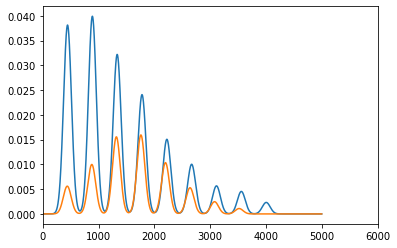

-----> {'amplitude': 0.0001, 'harm': 0, 'multiplier': 1, 'index': 0.10000000000000003}
-----> {'amplitude': 0.0559772764201907, 'harm': 1, 'multiplier': 1, 'index': 4.010752497594589}
-----> {'amplitude': 0.10272697332346686, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
-----> {'amplitude': 0.11367148974039583, 'harm': 3, 'multiplier': 1, 'index': 1.7641652598390003}
-----> {'amplitude': 0.07259538213992149, 'harm': 4, 'multiplier': 1, 'index': 4.216938642789974}
Pass 67, new penalty function: 81.034


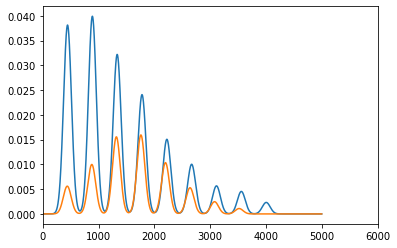

-----> {'amplitude': 9.99999999999994e-05, 'harm': 0, 'multiplier': 1, 'index': 0.1}
-----> {'amplitude': 0.0559772764201907, 'harm': 1, 'multiplier': 1, 'index': 4.010752497594589}
-----> {'amplitude': 0.10272697332346686, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
-----> {'amplitude': 0.11367148974039583, 'harm': 3, 'multiplier': 1, 'index': 1.7641652598390003}
-----> {'amplitude': 0.07259538213992149, 'harm': 4, 'multiplier': 1, 'index': 4.216938642789974}
Best parameters:  {'amplitude': 9.99999999999994e-05, 'harm': 0, 'multiplier': 1, 'index': 0.1}
{'amplitude': 0.0559772764201907, 'harm': 1, 'multiplier': 1, 'index': 4.010752497594589}
{'amplitude': 0.10272697332346686, 'harm': 2, 'multiplier': 1, 'index': 1.7905929881478446}
{'amplitude': 0.11367148974039583, 'harm': 3, 'multiplier': 1, 'index': 1.7641652598390003}
{'amplitude': 0.07259538213992149, 'harm': 4, 'multiplier': 1, 'index': 4.216938642789974}
Penalty function:  78.6246291467006


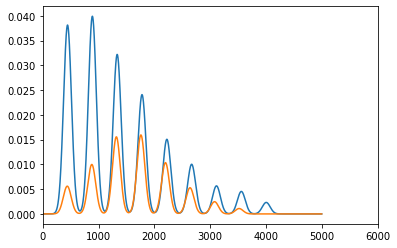

In [ ]:
alf = 0.0002
def penalty(xs, sim_ys, target_ys):
#  return 1000 * np.sum(np.square((sim_ys - target_ys) / np.exp(alf * xs)))
  return 1000000 * np.sum(np.square(sim_ys - target_ys)) / len(xs)
def smear(xs, ys, sigmasquared=1500,thresh=0.00005, xout=np.linspace(0,5000,100), decay=None): #decay not used
  peaks = [[xs[x],val] for x,val in enumerate(ys) if val > thresh and xs[x]>0]
  y_smeared = np.zeros(len(xout))
  for p in peaks:
    y_smeared += p[1] * np.exp(-0.5 * (xout - p[0])**2 / sigmasquared)

  return xout, y_smeared
# adjusted class for fixed harmonics
class GradientOptimizedMixer2(GradientOptimizedMixer):
  def __init__(self, num_operators=4, defaults={}, penalty=penalty,types={},par_range={}, steps={},gammas={},defstd={}):
    self.operators = []
    for i in range(num_operators):
        self.operators.append(GradientOptimizedCarrier(defaults={d:i+random.gauss(0,defstd[d]) for d,i in defaults.items()},penalty=penalty,types=types,par_range=par_range,steps=steps,gammas=gammas))
        # fix harmonic
        self.operators[i].vars["harm"] = i
        self.operators[i].carrier.harm = i
        del self.operators[i].grads["harm"]

        self.operators[i].vars["multiplier"] = 1
        self.operators[i].carrier.multiplier = 1
        del self.operators[i].grads["multiplier"]
    self.last_pen = 10000
    self.cached_xs = None
    self.cached_smp = None
    self.penalty = penalty
    self.sigsquared = 5000.0
    self.sample_points = 10000
    self.sigdecay = 0
  #test: smear both sample and the generated tone.
  def get_penalty(self, sample, slize, use_cached_sample=True, sample_sr=44100):
    if use_cached_sample and self.cached_smp is not None:
      _xs = self.cached_xs
      smp = self.cached_smp

    else:
      _xs, smp = self._get_stft_window(self._do_stft(sample), slize, sr=sample_sr)
      if use_cached_sample:
        self.cached_xs = _xs
        self.cached_smp = smp

    car_out = self._output()
    
    y_fft = fft(car_out)
    x_fft = fftfreq(len(car_out), 1/self.operators[0].carrier.sr)[:len(car_out)//2]
    y_fft = 2 * np.abs(y_fft[:len(car_out)//2]) / len(car_out)
    _xout = np.linspace(0,5000,self.sample_points)
    __xs, ysmr = smear(x_fft, y_fft, thresh=0.001,sigmasquared=self.sigsquared,xout=_xout)
    ___xs, _smp = smear(_xs, smp, sigmasquared=self.sigsquared, thresh=0.001, xout=_xout)
    return self.penalty(_xout, _smp, ysmr)
  def plot_progress(self, sample, slize, sample_sr=44100):
    _xs, smp = self._get_stft_window(self._do_stft(sample), slize, sr=sample_sr)
    car_out = self._output()
    y_fft = fft(car_out)
    x_fft = fftfreq(len(car_out), 1/self.operators[0].carrier.sr)[:len(car_out)//2]
    y_fft = 2 * np.abs(y_fft[:len(car_out)//2]) / len(car_out)
    xout = np.linspace(0,5000,self.sample_points)
    __xs, ysmr = smear(x_fft, y_fft, thresh=0.001,sigmasquared=self.sigsquared,xout=xout)
    ___xs, _smp = smear(_xs, smp, sigmasquared=self.sigsquared, thresh=0.001, xout=xout)
    plt.plot(___xs, _smp)
    plt.plot(__xs, ysmr)
    plt.xlim(left=0,right=6000)

test, _sr = librosa.load("TenorTrombone.ff.A4.stereo.aif")
# adjusted multiplier
gtest = GradientOptimizedMixer2(num_operators=5, defaults={"amplitude":0.15,"harm":4.0, "multiplier": 1.0, "index":3},
                                 steps={"amplitude":0.01,"harm":1.0, "multiplier":1.0, "index":0.2},
                                 gammas={"amplitude":0.000001,"harm":0.01, "multiplier":1,"index":0.0001},
                                 types={"amplitude":"float","harm":"int","multiplier":"int","index":"float"},
                                 par_range={"amplitude":(0.0001,0.2),"harm":(0,8),"multiplier":(0,10),"index":(0.1,50)},
                               defstd={"amplitude":0.05, "harm":2.0,"multiplier":2.0,"index":2})
pen = 1000000
lastBest = 0
best = pen
best_pars = gtest._vars()
bestBy = 0.1
iter = 0
cutoff = 20
print("Starting parameters:")
for o in gtest.operators:
  print("-> "+str(o.vars))

plt.show()
gtest.plot_progress(test, 50, sample_sr=_sr)
plt.show()
while pen > 1:
  iter+= 1
  new_pen = gtest.do_pass(test, 50, sample_sr=_sr,dropout=0.5)
  if new_pen < best - bestBy: 
    lastBest = iter
    best = new_pen
    best_pars = gtest._vars()
  pen = new_pen
  print("Pass {}, new penalty function: {:.5}".format(iter, pen))
  gtest.plot_progress(test, 50, sample_sr=_sr)
  plt.show()
  for o in gtest.operators:
    print("-----> "+str(o.vars))

  if iter - lastBest > cutoff:
    break

print("Best parameters: ", "\n".join([str(p) for p in best_pars]))
print("Penalty function: ", best)
gtest.set_vars(best_pars)
gtest.plot_progress(test, 50, sample_sr=_sr)

# Gradient Descent Carrier with RMSProp (adaptive learning rate)